# Modules, colors, and functions

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy
from scipy.ndimage.filters import gaussian_filter

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colorblind set
ClrBl = ['#ffa232', '#a61aa4', '#006600']

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)

# Histogram and scatter plot
def plotHistSqrtSSN(ax, calRefT, calObsT, Th, maxN, SqrtF):
    
    # Number of bins to use
    Nbins = maxN
    
    #Edges and Centers
    edges = np.arange(0,np.ceil(maxN)+np.round(maxN*0.25), (np.ceil(maxN))/Nbins) - (np.ceil(maxN))/Nbins/2
    centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2    
    
    # Applying Sqrt + 1
    if SqrtF:        
        maxN = np.sqrt(maxN)
        calRefT = np.sqrt(calRefT+1)
        calObsT = np.sqrt(calObsT+1)
        
        #Edges and Centers
        edges = np.arange(1,np.ceil(maxN)*1.05, (np.ceil(maxN))/Nbins) - (np.ceil(maxN))/Nbins/2
        centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2 
    
    # Average group number 
    ax.hist2d(calObsT, calRefT, bins=edges, cmap=plt.cm.magma_r,cmin=1)
    
    hist, xedges, yedges = np.histogram2d(calObsT, calRefT, bins=edges)
    alphaY = np.sum(hist,axis=1)/np.max(np.sum(hist,axis=1))*0.95+0.05
    
    # Calculating Quantities for plot and plot centers in Y
    Ymedian = centers*np.nan
    for i in range(0, centers.shape[0]):
        ypoints = calRefT[np.logical_and(calObsT>=edges[i], calObsT<=edges[i+1])]
        if ypoints.shape[0]>0:
            Ymedian[i] = np.nanmedian(ypoints)
            pecentilesy = np.abs(np.percentile(ypoints,np.array([15,85]), interpolation = 'linear')-Ymedian[i])
        
            xpoints = calObsT[np.logical_and(calRefT>=(Ymedian[i]-(np.ceil(maxN))/Nbins/2), calRefT<=(Ymedian[i]+(np.ceil(maxN))/Nbins/2))]
        
            if xpoints.shape[0]>0:
                pecentilesx = np.abs(np.percentile(xpoints,np.array([15,85]), interpolation = 'linear')-centers[i])
            else:
                pecentilesx = pecentilesy*0
        
            ax.errorbar(centers[i], Ymedian[i], yerr = np.expand_dims(pecentilesy,axis = 1), xerr = np.expand_dims(pecentilesx,axis = 1), color='k', zorder=11, alpha=alphaY[i])
            ax.scatter(centers[i], Ymedian[i], color='w', edgecolor='k', s=100, linewidths = 3, zorder=11, alpha=alphaY[i])

    # Calculating quantities for assessment
    y = Ymedian
    x = centers

    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)]

    # R squared
    yMean = np.mean(y)    
    SStot = np.sum(np.power(y-yMean,2)) 
    SSreg = np.sum(np.power(y-x,2))
    rSq   = (1 - SSreg/SStot)

    # Mean Residual
    mRes = np.mean(y-x)
    
    # Mean Relative Residual
    mRRes = np.mean(np.divide(y[x>0]-x[x>0],x[x>0]))    
    
    ax.plot(edges, edges, '--'
             , color = Clr[4], linewidth = 3)

    ax.text(0.5, 0.95,'$R^2M$=' + str(np.round(rSq,decimals=2)) + ' $MR$=' + str(np.round(mRes,decimals=2)) + ' $MRR$=' + str(int(np.round(mRRes*100,decimals=0))) + '% $Th$=' + str(Th), horizontalalignment='center', verticalalignment='center',transform=ax.transAxes)

    # Axes properties
    
    if SqrtF: 
        ax.set_xlabel('sqrt(GN+1) for ' + NamObs.capitalize())
        ax.set_ylabel('sqrt(GN+1) for reference')
    else:
        ax.set_xlabel('GN for ' + NamObs.capitalize())
        ax.set_ylabel('GN for reference observer')
        
    ax.set_xticks(np.arange(centers[0],np.ceil(centers[-1]), np.floor((np.ceil(centers[-1])-centers[0])/8)+1 ))
    ax.set_yticks(np.arange(centers[0],np.ceil(centers[-1]), np.floor((np.ceil(centers[-1])-centers[0])/8)+1 ))

        
# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading Reference data

We use a reduced version of the RGO and Debrecen data as provided by the [Heliophysical Observatory, Debrecen
](http://fenyi.solarobs.csfk.mta.hu/en/databases/GPR/).  Supplemented during cycle 24 with observations by the [Kidslovodsk Mountain Astronomical Station](http://dx.doi.org/10.7910/DVN/M7NDXN).  It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.

We add two more columns to the data:
    1. ORDINAL:  number of days after (0001,01,01).
    2. FRACYEAR: Fractional year for plotting.

In [4]:
REF_Dat = pd.read_csv('input_data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)
# Remove Years before 1902
REF_Dat = REF_Dat[REF_Dat['YEAR']>=1912].reset_index(drop=True)
REF_Dat['ORDINAL'] = REF_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
REF_Dat['FRACYEAR'] = REF_Dat.apply(lambda x: x['YEAR'].astype(int)
                                        + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                        / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                              ,axis=1)





# Turning reference areas into number of groups
REF_Grp = REF_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
REF_Grp['GROUPS'] = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1)
REF_Grp['GROUPS'] = REF_Grp['GROUPS'].astype(float)
REF_Grp.loc[np.isnan(REF_Dat['AREA1']), 'GROUPS'] = np.nan

# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
REF_Grp['AVGROUPS']  = conv.convolve(REF_Grp['GROUPS'].values,Gss_1D_ker)

REF_Dat

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


YEAR  MONTH  DAY  AREA1  AREA2  AREA3  AREA4  AREA5  AREA6  AREA7  ...  \
0      1912      1    1    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1      1912      1    2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2      1912      1    3    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3      1912      1    4    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4      1912      1    5    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
5      1912      1    6    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
6      1912      1    7    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
7      1912      1    8    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
8      1912      1    9    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
9      1912      1   10    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
10     1912      1   11    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
11     1912      1   12    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
12     1912      1   13    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
13     1912      1   14    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
14     1912      1   15    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
15     1912      1   16    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
16     1912      1   17    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
17     1912      1   18    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
18     1912      1   19    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
19     1912      1   20    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
20     1912      1   21    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
21     1912      1   22    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
22     1912      1   23    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
23     1912      1   24    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
24     1912      1   25    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
25     1912      1   26    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
26     1912      1   27    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
27     1912      1   28    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
28     1912      1   29    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
29     1912      1   30    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
...     ...    ...  ...    ...    ...    ...    ...    ...    ...    ...  ...   
38857  2018      5   21    6.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38858  2018      5   22   32.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38859  2018      5   23   22.0   44.0    NaN    NaN    NaN    NaN    NaN  ...   
38860  2018      5   24   18.0  136.0   30.0    NaN    NaN    NaN    NaN  ...   
38861  2018      5   25  123.0   63.0    NaN    NaN    NaN    NaN    NaN  ...   
38862  2018      5   26   40.0   67.0    NaN    NaN    NaN    NaN    NaN  ...   
38863  2018      5   27   11.0   56.0    NaN    NaN    NaN    NaN    NaN  ...   
38864  2018      5   28  144.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38865  2018      5   29  270.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38866  2018      5   30  149.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38867  2018      5   31  182.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38868  2018      6    1  224.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38869  2018      6    2  161.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38870  2018      6    3   48.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38871  2018      6    4    7.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38872  2018      6    5    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
38873  2018      6    6    7.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
38874  2018      6    7    4.0    NaN 

# Reading SILSO's total sunspot number

We use the current series to separate individual cycles from minimum to minimum.  We also identify all the minima present in the reference data, removing the first two minima to isolate potential drifts and systematic errors during the beginning of the RGO era.

In [5]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
SILSO_Sn_d = pd.read_csv('input_data/SN_d_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)

# Including daily value and interpolating
SILSO_Sn_d['MONTHSN']=SILSO_Sn_d['DAILYSN']
SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'] = np.interp(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'DAILYSN'])
SILSO_Sn_d['DAILYSN'] = SILSO_Sn_d['DAILYSN'].astype(float)


# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(365)
SILSO_Sn_d['AVGSNd']  = conv.convolve(SILSO_Sn_d['DAILYSN'].values,Gss_1D_ker)

# Smoothing
swin = 8 #Smoothing window in months
window = signal.gaussian(M=swin*6, std=swin)
window /= window.sum()

SILSO_Sn['MSMOOTH'] = np.convolve(SILSO_Sn['MMEAN'], window, mode='same')

# Finding maxima and minima
pkMax = detect_peaks(SILSO_Sn['MSMOOTH'], mpd=5)
pkMin = detect_peaks(-SILSO_Sn['MSMOOTH'], mpd=5)

SIL_max = SILSO_Sn.loc[pkMax, 'MSMOOTH'].values
SIL_maxT = SILSO_Sn.loc[pkMax, 'FRACYEAR'].values

SIL_min = SILSO_Sn.loc[pkMin, 'MSMOOTH'].values
SIL_minT = SILSO_Sn.loc[pkMin, 'FRACYEAR'].values

# Identify minima covered by the reference data
REF_min = SIL_min[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
REF_minT = SIL_minT[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]

# Identify axima covered by the reference data
REF_max = SIL_max[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]
REF_maxT = SIL_maxT[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]


# # Remove first two cycles
#REF_min = REF_min[2:REF_min.shape[0]]
#REF_minT = REF_minT[2:REF_minT.shape[0]]

# REF_max = REF_max[2:REF_max.shape[0]]
# REF_maxT = REF_maxT[2:REF_maxT.shape[0]]

# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

We recast the number of groups as a float so that we can use NaNs for days with missing observations.

In [6]:
GN_Dat = pd.read_csv('input_data/GNObservations_JV_V1.22.csv', quotechar = '"', encoding = 'ansi',header = 15)
GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)

## Reading observers

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

The **_print_** statement on this cell can be use for reference as it shows the station number associated with each observer.

In [7]:
GN_Obs = pd.read_csv('input_data/GNObservers_JV_V1.22.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs[['INITIAL','FINAL','STATION','OBSERVER','TOT.OBS']].to_string())

UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

     INITIAL   FINAL  STATION                                   OBSERVER  TOT.OBS
0     1610.0  1613.0        1                        HARRIOT, T., OXFORD      210
1     1611.0  1640.0        2                         SCHEINER, C., ROME      882
2     1612.0  1612.0        3                          GALILEO, G., ROME       51
3     1612.0  1612.0        4                      GALILEO-SAKURAI, ROME       37
4     1612.0  1612.0        5                      COLOGNA, S., MONREALE       20
5     1612.0  1613.0        6                       JUNGIUS, J., HAMBURG      104
6     1612.0  1612.0        7                         CIGOLI, L.C., ROME       29
7     1613.0  1614.0        8                        COLONNA, F., NAPLES       51
8     1615.0  1617.0        9                          TARDE, J., FARLAT       57
9     1616.0  1616.0       10                    SAXONIUS, P., NUREMBERG       12
10       NaN     NaN       11                      MARIUS, S., NUREMBERG        0
11    1618.0  16

<a id='observer'></a>
# Processing observer

This cell picks the observer that will be calibrated to REF.  Some interesting observers are:

* Spörer: 318 (lots of missing zeros)
* Leppig: 324 (short and consistent, but with lots of missing days)
* Wolfer: 338 (long and dense)

It is interesting to see if the time optimization can get the proper time accurately.  Some observers that do:

* Moye: 412 (1 cycle)
* Broger: 370 (4 cycles)

Some that don't

* Woinoff: 376 (2 cycles, very strong yearly variation)

Other long observers with overlap are:

* Sykora: 366
* Guillaume: 386
* Stempell: 389 (lots of gaps)
* Koyama: 445
* National astron. ob. Japan: 447

Observations for the chosen observer are filled with NaNs for days without observations.


In [8]:
# Observer Station Number
CalObs = 407
NamObs = GN_Obs['OBSERVER'].values[GN_Obs['STATION'].values==CalObs]
NamObs = NamObs[0]
NamObs = NamObs[0:NamObs.find(',')]

#print(NamObs)

# Picking observations
ObsDat = GN_Dat[GN_Dat.STATION == CalObs].copy()

# Finding missing days
ObsInt  = np.arange(np.min(ObsDat['ORDINAL']), np.max(ObsDat['ORDINAL']+1))
MisDays =  np.logical_not(sp.in1d(ObsInt, ObsDat['ORDINAL'] ))

# Creating dataframe with NaNs for days without observations
year  = np.array(list(map(lambda x: datetime.date.fromordinal(x).year, ObsInt[MisDays])))
month = np.array(list(map(lambda x: datetime.date.fromordinal(x).month, ObsInt[MisDays])))
day   = np.array(list(map(lambda x: datetime.date.fromordinal(x).day, ObsInt[MisDays])))

station  = day*0+CalObs
observer = day*0+1
groups   = day*np.nan

fractyear = np.array(list(map(lambda year, month, day : year + (  datetime.date(year, month , day).toordinal()
                                            - datetime.date(year,1,1).toordinal() )
                                            / (  datetime.date(year+1,1,1).toordinal()
                                            - datetime.date(year,1,1).toordinal() ), year, month, day)))

NoObs = pd.DataFrame(np.column_stack((year, month, day, ObsInt[MisDays], station, observer, groups, fractyear)), columns = ObsDat.columns.values)

# Append dataframe with missing days
ObsDat = ObsDat.append(NoObs,ignore_index=True)

# Recast using original data types
origType = GN_Dat.dtypes.to_dict()
ObsDat = ObsDat.apply(lambda x: x.astype(origType[x.name]))

# Sorting according to date
ObsDat = ObsDat.sort_values('ORDINAL').reset_index(drop=True)

In [9]:
# Final data for RGO and given observer
cond1=pd.merge(SILSO_Sn_d, ObsDat, on=['YEAR', 'MONTH', 'DAY'], how='inner')
cond2=pd.merge(SILSO_Sn_d, REF_Grp, on=['YEAR', 'MONTH', 'DAY'], how='inner')
print(cond1)

ObsDat=ObsDat.join(cond1['AVGSNd'])
REF_Grp=REF_Grp.join(cond2['AVGSNd'])
print(ObsDat)
print(REF_Grp)

      YEAR  MONTH  DAY  FRACYEAR_x  DAILYSN  DAILYSTD  NOBS  MARKER  MONTHSN  \
0     1909      1    2    1909.004    102.0       9.0     1       1    102.0   
1     1909      1    3    1909.007     60.0       6.9     1       1     60.0   
2     1909      1    4    1909.010     63.0       7.1     1       1     63.0   
3     1909      1    5    1909.012     62.0       7.0     1       1     62.0   
4     1909      1    6    1909.015     30.0       4.9     1       1     30.0   
5     1909      1    7    1909.018     87.0       8.3     1       1     87.0   
6     1909      1    8    1909.021     97.0       8.8     1       1     97.0   
7     1909      1    9    1909.023     80.0       8.0     1       1     80.0   
8     1909      1   10    1909.026     87.0       8.3     1       1     87.0   
9     1909      1   11    1909.029     53.0       6.5     1       1     53.0   
10    1909      1   12    1909.032     47.0       6.1     1       1     47.0   
11    1909      1   13    1909.034     3

<a id='duration'></a>
## Recasting observations into equal intervals of specified duration


To simplify and speedup the analysis we segment the observational interval using "months" of arbitrary length. This allows us to reshape our time series into a matrix and perform matrix-vector operations that are much faster than for loops.

Only an integer amount of "months" is used in order to make the reshaping operation possible.

In [10]:
# Number of days per "month"
MoLngt = 15

# OBSERVER
# Selecting the maximum integer amount of "months" out of the original data
grpsOb = ObsDat['GROUPS'].values
grpsOb = grpsOb[0:np.int(grpsOb.shape[0]/MoLngt)*MoLngt]

ordOb = ObsDat['ORDINAL'].values
ordOb = ordOb[0:np.int(ordOb.shape[0]/MoLngt)*MoLngt]

yrOb = ObsDat['FRACYEAR'].values
yrOb = yrOb[0:np.int(yrOb.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsOb = grpsOb.reshape((-1,MoLngt))
ordOb  = ordOb.reshape((-1,MoLngt))
yrOb   = yrOb.reshape((-1,MoLngt))

<a id='coverage'></a>
## Calculating number of days with observations and number of days with groups 

In [11]:
# OBSERVER

# Minimum fraction of observed days for an interval to be considered useful
minObD = 0.33;

# Number of days with observations
obsOb = np.sum(np.isfinite(grpsOb),axis=1)

# Number of days with groups
grpOb = np.sum(np.greater(grpsOb,0),axis=1)

# Average number of groups
Gss_1D_ker = conv.Gaussian1DKernel(2)
AvGrpOb = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker)
SdGrpOb = np.nanstd(grpsOb,axis=1)

# Interval edges for plotting
fyr1Ob = np.min(yrOb,axis=1)
fyr2Ob = np.max(yrOb,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<a id='#subintervals'></a>
## Breaking Observer Period into rising (decaying) Intervals

We break the observational period into cycles going from minimum to maximum, and maximum to minumum, in order to ease the capability of the algorithm to find the best matches during the reference era.

In [12]:
# Minimum number of days with group measurements    
minGrpDays = 100

# Maximum number of valid intervals to use
maxValInt = 3

# Finding internal endpoints and centers of SILSO

# Assinging max (1) and min (-1) labels to endpoints
maxPointsS = np.expand_dims(SIL_maxT,1)
maxPointsS = np.concatenate((maxPointsS,maxPointsS*0+1),axis=1)

minPointsS = np.expand_dims(SIL_minT,1)
minPointsS = np.concatenate((minPointsS,minPointsS*0-1),axis=1)

# Creating endpoints matrix
endPointsS = np.append(maxPointsS,minPointsS,axis=0)

# Sorting endpoints
endPointsS = endPointsS[endPointsS[:,0].argsort()]

# Finding centers and classifying them as rising (1) and decaying (-1)
cenPointsS = (endPointsS[1:endPointsS.shape[0],:]+endPointsS[0:endPointsS.shape[0]-1,:])/2
cenPointsS[:,1] = endPointsS[1:endPointsS.shape[0],1]


# Finding internal endpoints and centers of Reference
endPointsR = endPointsS[np.logical_and(endPointsS[:,0]>np.min(REF_Dat['FRACYEAR']),endPointsS[:,0]<np.max(REF_Dat['FRACYEAR'])),:]
cenPointsR = (endPointsR[1:endPointsR.shape[0],:]+endPointsR[0:endPointsR.shape[0]-1,:])/2
cenPointsR[:,1] = endPointsR[1:endPointsR.shape[0],1]


# Finding internal endpoints and centers of Observer Intervals are included if their center is covered by the observer

# Defining boolean array of valid endpoints
validEnd = np.logical_and(endPointsS[:, 0] > np.min(yrOb),endPointsS[:, 0] < np.max(yrOb))


# Adding a True on the index prior to the first endpoint to include the bracketing point
validEnd[0:validEnd.shape[0] - 2] = np.logical_or(validEnd[0:validEnd.shape[0] - 2],
                                                  validEnd[1:validEnd.shape[0] - 1])

# Adding a True on the index after the last endpoint to include the bracketing point
validEnd[2:validEnd.shape[0] - 0] = np.logical_or(validEnd[2:validEnd.shape[0]],
                                                  validEnd[1:validEnd.shape[0] - 1])

# Defining arrays
endPoints = endPointsS[validEnd]


cenPoints = (endPoints[1:endPoints.shape[0],:]+endPoints[0:endPoints.shape[0]-1,:])/2
cenPoints[:,1] = endPoints[1:endPoints.shape[0],1]


# Identification of Min-Max Max-Min intervals with enough valid "months"
vldIntr = np.zeros(cenPoints.shape[0])

for siInx in range(0,cenPoints.shape[0]):
    
    # Redefining endpoints if interval is partial
    if endPoints[siInx, 0] < np.min(ObsDat['FRACYEAR']):
        print('Redefining left endpoint')
        endPoints[siInx, 0] = np.min(ObsDat['FRACYEAR'])
        
    if endPoints[siInx+1, 0] > np.max(ObsDat['FRACYEAR']):
        print('Redefining right endpoint')
        endPoints[siInx+1, 0] = np.max(ObsDat['FRACYEAR'])
    
    print('Center:',np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
    
    # Number of days with sunspot observations
    vldIntr[siInx] = np.sum(TObsDat>0)


# Checking if there are valid intervals    
vldIntr[vldIntr<minGrpDays] = 0
if np.sum(vldIntr)==0:
    print('NO VALID INTERVALS IN OBSERVER')

# If more than the maximum, retain only the intervals with the lagest number of days
elif np.sum(vldIntr>0)>maxValInt:
    I = np.argsort(vldIntr)[::-1]
    vldIntr[vldIntr<vldIntr[I][2]] = np.nan

# Remove invalid intervals    
vldIntr[vldIntr==0] = np.nan

Redefining left endpoint
Center: 1909.71 Edges: 1909.0 1913.12
Center: 1915.5 Edges: 1913.12 1917.87
Center: 1920.66 Edges: 1917.87 1923.46
Redefining right endpoint
Center: 1925.83 Edges: 1923.46 1925.99


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


## Plotting comparison the observer's active vs. observed days per month

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in greater


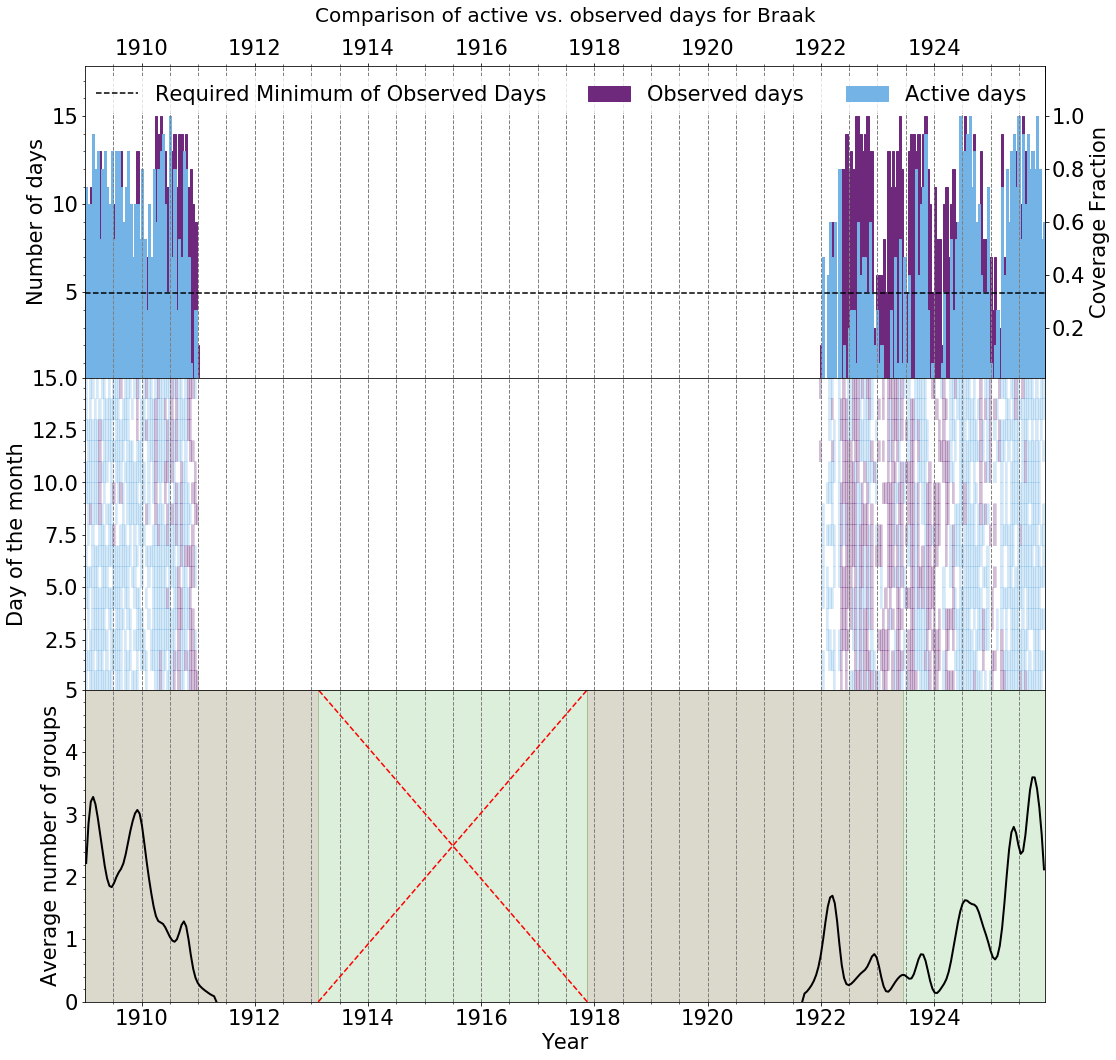

In [13]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltxOb = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltxOb = np.append(pltxOb,np.max(fyr2Ob))
pltxOb = np.append(pltxOb,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAvOb = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAvOb = np.insert(pltyAvOb,0,0)
pltyAvOb = np.append(pltyAvOb,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltxOb, pltyOb, color = Clr[2])
ax1.fill(pltxOb, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

ax1.plot(np.array([np.min(pltxOb),np.max(pltxOb)]), np.array([1,1])*minObD*MoLngt, 'k--')



# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Required Minimum of Observed Days','Observed days','Active days'], loc = 'upper right', ncol = 3, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

for Idx in range(0,cenPoints.shape[0]):
    if vldIntr[Idx]:
        ax3.fill([endPoints[Idx, 0], endPoints[Idx, 0], endPoints[Idx+1, 0], endPoints[Idx+1, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1, np.ceil(np.nanmax(AvGrpOb))+1, 0 ], color = Clr[1+np.mod(Idx,2)*2], alpha = 0.2)
        if np.isnan(vldIntr[Idx]):
            ax3.plot([endPoints[Idx, 0], endPoints[Idx+1, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1], color = 'r', linestyle='--')
            ax3.plot([endPoints[Idx+1, 0], endPoints[Idx, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1], color = 'r', linestyle='--')

            ##### Removing interval from pool
            vldIntr[Idx] = 0
        
        
ax3.plot((fyr1Ob+fyr2Ob)/2, AvGrpOb, color = Clr[0], linewidth = 2)



# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0, top = np.ceil(np.nanmax(AvGrpOb))+1);

fig.savefig('testBoth/' + NamObs.capitalize() + '_Data.png', bbox_inches='tight', dpi = 103, pad_inches=0)

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.  Shaded areas indicate the separation of observations in sub-domains roughly going from maximum to maximum.  **White intervals are not used in calibration due to the interval being too small or not having good coverage**

<a id='#parameters'></a>
## Calculating the solar minimum masks that will be used in the optimization scan for best match

Given that our objective is to calculate the relative of different cycles we can take advantage of our knowledge of cycle progression to narrow the search for an optimum.  To do this we create a mask of valid search periods determined by using a window centered on the minima contained within the reference data.

In [14]:
# Temporal Stride in days
dt = 5

# Cycle phase tolerance in years
phTol = 1.5

# Creating window masks
risMask = np.zeros(REF_Grp.shape[0], dtype=bool)
decMask = np.zeros(REF_Grp.shape[0], dtype=bool)

# Applying mask
for cen in cenPointsR:
    if cen[1]==1:  
        risMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True
    else:
        decMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True
        
# Creating cadence mask
cadMask = np.zeros(REF_Grp.shape[0], dtype=bool)
cadMask[range(0,cadMask.shape[0],dt)] = True

# Removing early cycles
# cadMask[REF_Grp['FRACYEAR'].values<1900] = False

#Storing maks for plotting
risMaskP = risMask.copy()
decMaskP = decMask.copy()

# Creating rising mask
risMask = np.logical_and(cadMask,risMask)

# Creating decaying mask
decMask = np.logical_and(cadMask,decMask)

# Turnings Mask into indices
risMaskI = np.array(risMask.nonzero()[0])
decMaskI = np.array(decMask.nonzero()[0])

## Plotting maxima, minima, and search windows

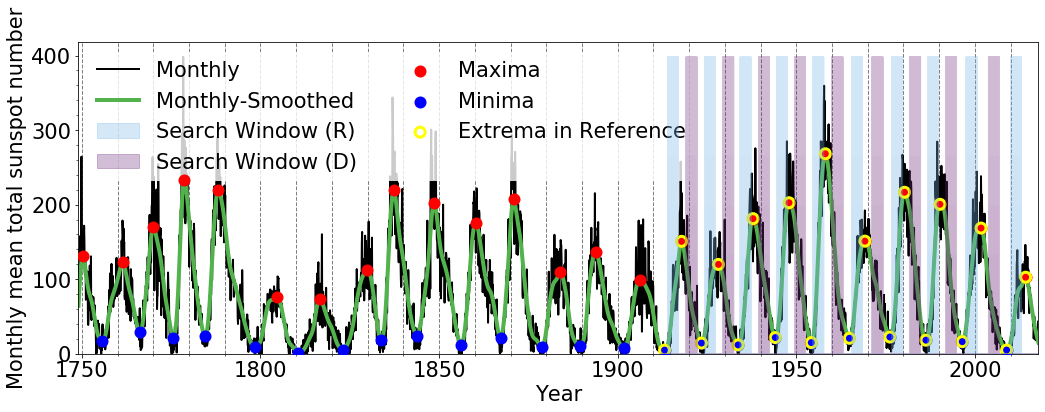

In [15]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2)
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MSMOOTH'], color = Clr[3], linewidth = 4)
ax1.scatter(SIL_maxT, SIL_max, color='r', edgecolor='r', alpha = 1, s=100, linewidths = 2, zorder=10)
ax1.scatter(SIL_minT, SIL_min, color='b', edgecolor='b', alpha = 1, s=100, linewidths = 2, zorder=10)
ax1.scatter(REF_minT, REF_min, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10)
ax1.scatter(REF_maxT, REF_max, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10)
ax1.fill(REF_Grp['FRACYEAR'],  risMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[4], color = Clr[4], alpha = 0.3, zorder=15)
ax1.fill(REF_Grp['FRACYEAR'],  decMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[2], color = Clr[2], alpha = 0.3, zorder=15)


ax1.legend(['Monthly','Monthly-Smoothed','Search Window (R)','Search Window (D)','Maxima', 'Minima','Extrema in Reference'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')

# Axes properties
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly mean total sunspot number')
ax1.set_xlim(left = np.min(SILSO_Sn['FRACYEAR']), right = np.max(SILSO_Sn['FRACYEAR']))
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.minorticks_on()
ax1.set_ylim(bottom = 0);

**FIGURE:** Maxima and minima determinid using SILSO's v2 series.  This help us reduce significantly the number of steps on the optimization scan.  This way, rising (decaying) phases of the observer only need to be compared with rising (decaying) phasis of the reference

## Distribution of threshold sensitive quantities

The amount of grups visible on a given day depends both on activity level and threshold, as well as how many continuous days without spots we have.  Both can be used to constraint the threshold, complementing ADF.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anacond

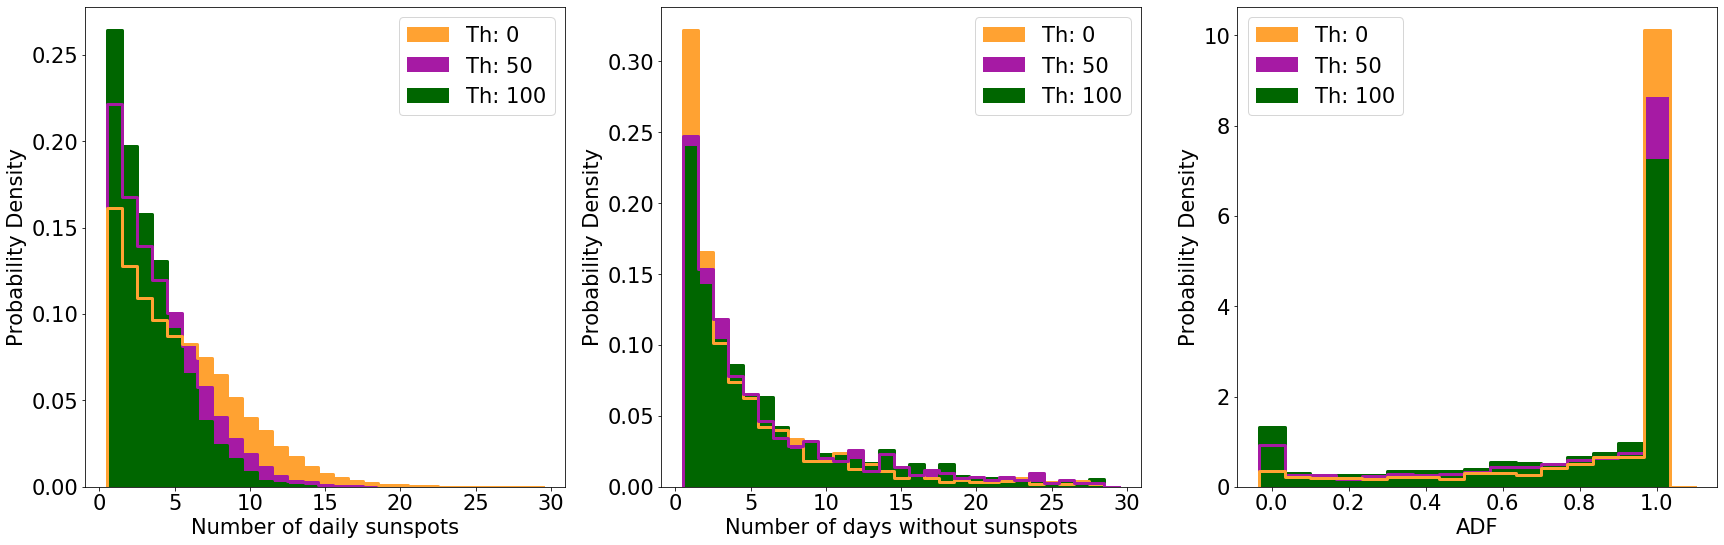

In [16]:
bins = np.arange(1,30)-0.5


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 400 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units
ppxx = pxx/fszh
ppxy = pxy/fszv


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Number of spots on a day
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])

Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1).astype(float)
ax1.hist(Gref, bins=bins, density = True, color = ClrBl[0], label = 'Th: 0')
bins1, data1 = histOutline(Gref, bins=bins, density = True)

Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],50) ,axis = 1).astype(float)
ax1.hist(Gref, bins=bins, density = True, alpha = 1, color = ClrBl[1], label = 'Th: 50')
bins2, data2 = histOutline(Gref, bins=bins, density = True)

Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],100) ,axis = 1).astype(float)
ax1.hist(Gref, bins=bins, density = True, alpha = 1, color = ClrBl[2], label = 'Th: 100')
bins3, data3 = histOutline(Gref, bins=bins, density = True)

ax1.plot(bins3, data3, color = ClrBl[2], linewidth = 3)
ax1.plot(bins2, data2, color = ClrBl[1], linewidth = 3)
ax1.plot(bins1, data1, color = ClrBl[0], linewidth = 3)

ax1.set_ylabel('Probability Density')
ax1.set_xlabel('Number of daily sunspots');
ax1.legend()



## Number continuous days without sunspots
ax2 = fig.add_axes([ppadh+ppxx+ppadh2, ppadv, ppxx, ppxy])

Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1).astype(float)
# Find indices of zeros
zeroIn = (np.logical_not(Gref==0)).nonzero()[0]
# Find differences to identify gaps
ObsQInt = zeroIn[1:zeroIn.shape[0]]-zeroIn[0:zeroIn.shape[0]-1]-1
ObsQInt = ObsQInt[ObsQInt>0]

# Adding first interval if first day of survey is zero
if Gref[0]==0:
    ObsQInt = np.insert(ObsQInt, 0, zeroIn[0])

ax2.hist(ObsQInt, bins=bins, density = True, color = ClrBl[0], label = 'Th: 0')
bins1, data1 = histOutline(ObsQInt, bins=bins, density = True)


Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],50) ,axis = 1).astype(float)
# Find indices of zeros
zeroIn = (np.logical_not(Gref==0)).nonzero()[0]
# Find differences to identify gaps
ObsQInt = zeroIn[1:zeroIn.shape[0]]-zeroIn[0:zeroIn.shape[0]-1]-1
ObsQInt = ObsQInt[ObsQInt>0]

# Adding first interval if first day of survey is zero
if Gref[0]==0:
    ObsQInt = np.insert(ObsQInt, 0, zeroIn[0])

ax2.hist(ObsQInt, bins=bins, density = True, alpha = 1, color = ClrBl[1], label = 'Th: 50')
bins2, data2 = histOutline(ObsQInt, bins=bins, density = True)


Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],100) ,axis = 1).astype(float)
# Find indices of zeros
zeroIn = (np.logical_not(Gref==0)).nonzero()[0]
# Find differences to identify gaps
ObsQInt = zeroIn[1:zeroIn.shape[0]]-zeroIn[0:zeroIn.shape[0]-1]-1
ObsQInt = ObsQInt[ObsQInt>0]

# Adding first interval if first day of survey is zero
if Gref[0]==0:
    ObsQInt = np.insert(ObsQInt, 0, zeroIn[0])


ax2.hist(ObsQInt, bins=bins, density = True, alpha = 1, color = ClrBl[2], label = 'Th: 100')
bins3, data3 = histOutline(ObsQInt, bins=bins, density = True)


ax2.plot(bins3, data3, color = ClrBl[2], linewidth = 3)
ax2.plot(bins1, data1, color = ClrBl[0], linewidth = 3)
ax2.plot(bins2, data2, color = ClrBl[1], linewidth = 3)


ax2.set_ylabel('Probability Density')
ax2.set_xlabel('Number of days without sunspots');
ax2.legend()



## Active day fraction
bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt

ax3 = fig.add_axes([ppadh+2*(ppxx+ppadh2), ppadv, ppxx, ppxy])

Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1).astype(float)
Gref[np.isnan(REF_Dat['AREA1'])] = np.nan
Gref = Gref[0:np.int(Gref.shape[0]/MoLngt)*MoLngt]
Gref = Gref.reshape((-1,MoLngt)) 
Gref = np.sum(np.greater(Gref,0),axis=1)/np.sum(np.isfinite(Gref),axis=1)

ax3.hist(Gref, bins=bins, density = True, color = ClrBl[0], label = 'Th: 0')
bins1, data1 = histOutline(Gref, bins=bins, density = True)

Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],50) ,axis = 1).astype(float)
Gref[np.isnan(REF_Dat['AREA1'])] = np.nan
Gref = Gref[0:np.int(Gref.shape[0]/MoLngt)*MoLngt]
Gref = Gref.reshape((-1,MoLngt)) 
Gref = np.sum(np.greater(Gref,0),axis=1)/np.sum(np.isfinite(Gref),axis=1)

ax3.hist(Gref, bins=bins, density = True, alpha = 1, color = ClrBl[1], label = 'Th: 50')
bins2, data2 = histOutline(Gref, bins=bins, density = True)

Gref = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],100) ,axis = 1).astype(float)
Gref[np.isnan(REF_Dat['AREA1'])] = np.nan
Gref = Gref[0:np.int(Gref.shape[0]/MoLngt)*MoLngt]
Gref = Gref.reshape((-1,MoLngt)) 
Gref = np.sum(np.greater(Gref,0),axis=1)/np.sum(np.isfinite(Gref),axis=1)

ax3.hist(Gref, bins=bins, density = True, alpha = 1, color = ClrBl[2], label = 'Th: 100')
bins3, data3 = histOutline(Gref, bins=bins, density = True)

ax3.plot(bins3, data3, color = ClrBl[2], linewidth = 3)
ax3.plot(bins2, data2, color = ClrBl[1], linewidth = 3)
ax3.plot(bins1, data1, color = ClrBl[0], linewidth = 3)

ax3.set_ylabel('Probability Density')
ax3.set_xlabel('ADF');
ax3.legend()


# Calculating number of active and observed days

For each of the observer subintervals specified in [**"Breaking Observer Period into rising (decaying) Intervals"**](#subintervals) we do a window scan during the rising (decays) contained in the reference.  For each step in the window scan we:

* Select an interval in the reference of equal duration as in the observer's sub-interval.
* Imprint missing days on both reference and observer
* Calculate number of active days and number of days with observations

## The Earth Mover's Distance (Wasserstein metric)

As part of our effort to make ADF more robust we introduce the Earth Mover's distance (EMD) to quantify how different are the Observer's and reference's distribution of ADFs.

[See description paper here](http://ai.stanford.edu/~rubner/papers/rubnerIjcv00.pdf)

The basic idea of the EMD is to depict distributions as piles of dirt and quantify the amount of "work" that an earth mover would need to do in order to transform one distribution into the other.   Here we use the pyemd package:

[https://github.com/wmayner/pyemd](https://github.com/wmayner/pyemd)



## Calculating the Earth's Mover Distance using a sliding window 

The idea is to optimize the fit between the reference and different sections of the observer's ADF distributions simultaneously in time and threshold.  The cell below performs this operation.  We use prior knowledge of cycle progression to limit the search to periods around cycle minimum (the centerpoints of our sub-intervals).

In [17]:
from pyemd import emd

#Starting threshold
thS = 0
# Ending threshold
thE = 130
# Threshold increments
thI = 1

Thresholds = np.arange(thS,thE+thI,thI)

# Switch that forces the code to ignore the true overlapping phase in calibration if present
noOvrlpSw = True

# Calculation of distance matrix to be used in the Earth Movers Metric for Groups
NGrpsBins = 30
x = np.arange(0,NGrpsBins+1)
y = np.arange(0,NGrpsBins+1)
xx, yy = np.meshgrid(x, y)
DisG = np.absolute(np.power(xx-yy,1))

# Distance between distributions of sunspot groups for interval
EMDtD = [] 
EMDthD = []
EMDGr = []

# Distributions
grpDirObsI = []
grpDirREFI = []

# Number of observations
grpNObsI = []
grpNREFI = []

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):  
    print('Center:', np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Perform analysis Only if the period is valid
    if vldIntr[siInx]:
    
        print('Valid Interval')
        
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0:
            cadMaskI = risMaskI
        else:
            cadMaskI = decMaskI
            
        # Selecting interval
        TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'GROUPS'].values.copy()
        TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'FRACYEAR'].values.copy()                

        # Find index of center of sub-interval
        minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx, 0]))
        obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx, 0])==minYear).nonzero()[0][0]

        # Pre-allocating EMD matrix and associated coordinate matrices.  A large default distance valued is used 
        # to account for missing points
        EMDGrt = np.ones((Thresholds.shape[0],cadMaskI.shape[0]))*1e16
        EMDt   = np.zeros((Thresholds.shape[0],cadMaskI.shape[0]))
        EMDth  = np.zeros((Thresholds.shape[0],cadMaskI.shape[0]))         

        grpNObs = np.zeros((Thresholds.shape[0],cadMaskI.shape[0])) 
        grpNREF = np.zeros((Thresholds.shape[0],cadMaskI.shape[0]))         
        
        # Group distributions
        grpDirObs = np.zeros((Thresholds.shape[0],cadMaskI.shape[0],NGrpsBins))
        grpDirREF = np.zeros((Thresholds.shape[0],cadMaskI.shape[0],NGrpsBins))

        # Going through different thresholds
        for TIdx, Thr in enumerate(Thresholds):

            # Calculating number of groups in reference data for given threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],Thr) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan                
                
            # Going through different shifts
            for SIdx in range(0,cadMaskI.shape[0]): 

                #Calculating bracketing indices
                Idx1 = cadMaskI[SIdx]-obsMinInx
                Idx2 = Idx1 + TObsDat.shape[0] 
                                
                # Making sure there is no observational overlap between observer and reference
                if np.logical_or(np.logical_not(noOvrlpSw), np.logical_or(np.min(REF_Dat['FRACYEAR'][Idx1:Idx2])>np.max(TObsFYr), np.max(REF_Dat['FRACYEAR'][Idx1:Idx2])<np.min(TObsFYr))):
                
                    #Selecting reference window of matching size to observer sub-interval;
                    TgrpsREF = grpsREFw[Idx1:Idx2].copy()
                    TgrpsOb = TObsDat.copy()
                    
                    # Making sure selections have the same length
                    if TgrpsREF.shape[0] == TgrpsOb.shape[0]:
                    
                        # Imprinting missing days
                        # OBSERVER
                        TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                        # REFERENCE
                        TgrpsREF[np.isnan(TgrpsOb)] = np.nan
                        
                        # Retaining only non-nans and non-zeros
                        TgrpsOb  = TgrpsOb[TgrpsOb>0]
                        TgrpsREF = TgrpsREF[TgrpsREF>0]
                        
                        # Number of observations
                        grpNObs[TIdx,SIdx] = TgrpsOb.shape[0]
                        grpNREF[TIdx,SIdx] = TgrpsREF.shape[0]                        
                        
                        # Calculating Earth Mover's Distance for group numbers
                        DisObs, bins = np.histogram(TgrpsOb, bins= (np.arange(1,NGrpsBins+2)-0.5), density = True)
                        DisREF, bins = np.histogram(TgrpsREF, bins= (np.arange(1,NGrpsBins+2)-0.5), density = True)                

                        # Storing EMD
                        EMDGrt[TIdx,SIdx] = emd(DisREF.astype(np.float64),DisObs.astype(np.float64),DisG.astype(np.float64))                           
#                         EMDGrt[TIdx,SIdx] = np.nanmean(np.power(DisObs-DisREF,2))  

                        # Storing Distributions
                        grpDirObs[TIdx,SIdx,:] = DisObs
                        grpDirREF[TIdx,SIdx,:] = DisREF
        
                        # Storing coordinates of EMD distances
                        EMDt[TIdx,SIdx] = REF_Grp['FRACYEAR'].values[cadMaskI[SIdx]]
                        EMDth[TIdx,SIdx]= Thr        
    
    # If period is not valid append empty variavbles
    else:        
        print('INVALID Interval')        
        EMDGrt = []
        EMDt = []
        EMDth = []        
        grpDirObs = []
        grpDirREF = []
        grpNObs = []
        grpNREF = []
        
    print(' ')  
    
    # Appending calculated days to list of sub-intervals
    EMDGr.append(EMDGrt)
    EMDtD.append(EMDt)
    EMDthD.append(EMDth)    
    grpDirObsI.append(grpDirObs)
    grpDirREFI.append(grpDirREF)
    grpNObsI.append(grpNObs)
    grpNREFI.append(grpNREF) 

Center: 1909.71 Edges: 1909.0 1913.12
Valid Interval


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in greater


 
Center: 1915.5 Edges: 1913.12 1917.87
INVALID Interval
 
Center: 1920.66 Edges: 1917.87 1923.46
Valid Interval
 
Center: 1925.83 Edges: 1923.46 1925.99
Valid Interval
 


## Finding nbest matches for the group number and ADF distributions

In [18]:
# Number of top best matches to keep
nBest = 100
nBest2 = 10

# Maximum perceptual difference between number of days
maxdiff = 0.1

# Creating Storing dictionaries to store best thresholds
bestThGrp = []

minGrp = 1e10
maxGrp = 0

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    # Plot Matrix Only if the period is valid
    if vldIntr[siInx]:
        
        # Smooth EMD (threshold, cadence)
        EMDGr[siInx] = gaussian_filter(EMDGr[siInx], (0.5,0.5), mode='reflect', cval=1e16)
            
        # Creating matrix for sorting and find the best combinations of threshold and shift
        OpMat = np.concatenate((EMDtD[siInx].reshape((-1,1)), EMDthD[siInx].reshape((-1,1)), EMDGr[siInx].reshape((-1,1)), np.abs(grpNObsI[siInx].reshape((-1,1))-grpNREFI[siInx].reshape((-1,1)))/grpNObsI[siInx].reshape((-1,1))), axis = 1)

        # Sort according to EMD to find the best matches
        I = np.argsort(OpMat[:,2],axis = 0)
        OpMat = np.squeeze(OpMat[I,:])

        minGrp = np.nanmin([minGrp, OpMat[0,2]])
        maxGrp = np.nanmax([maxGrp, np.nanpercentile(OpMat[:,2],10)])

        # Grab the best matches        
        OpMat = OpMat[0:nBest,:]
        
#         # Remove points above max diff        
#         OpMat = OpMat[OpMat[:,3]<=maxdiff,:]
        
        # Sort according to number of non-zero observations
        I = np.argsort(OpMat[:,3],axis = 0)
        OpMat = np.squeeze(OpMat[I,:])
        
        # Grab the best matches        
        OpMat = OpMat[0:nBest2,:]
        
        # Sort according to EMD
        I = np.argsort(OpMat[:,2],axis = 0)
        OpMat = np.squeeze(OpMat[I,:])        
        
        # Adding best points
        bestThGrp.append(OpMat)     
        
    # If period not valid store an empty array
    else:
        bestThGrp.append([])
        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


<a id='#parametersBest'></a>
## Plotting the optimization matrix between reference and observer in terms of groups for each sub-interval separately 

For comparison, if the observer has a coincident time with the reference, we also calculate the EMD using exact matches.


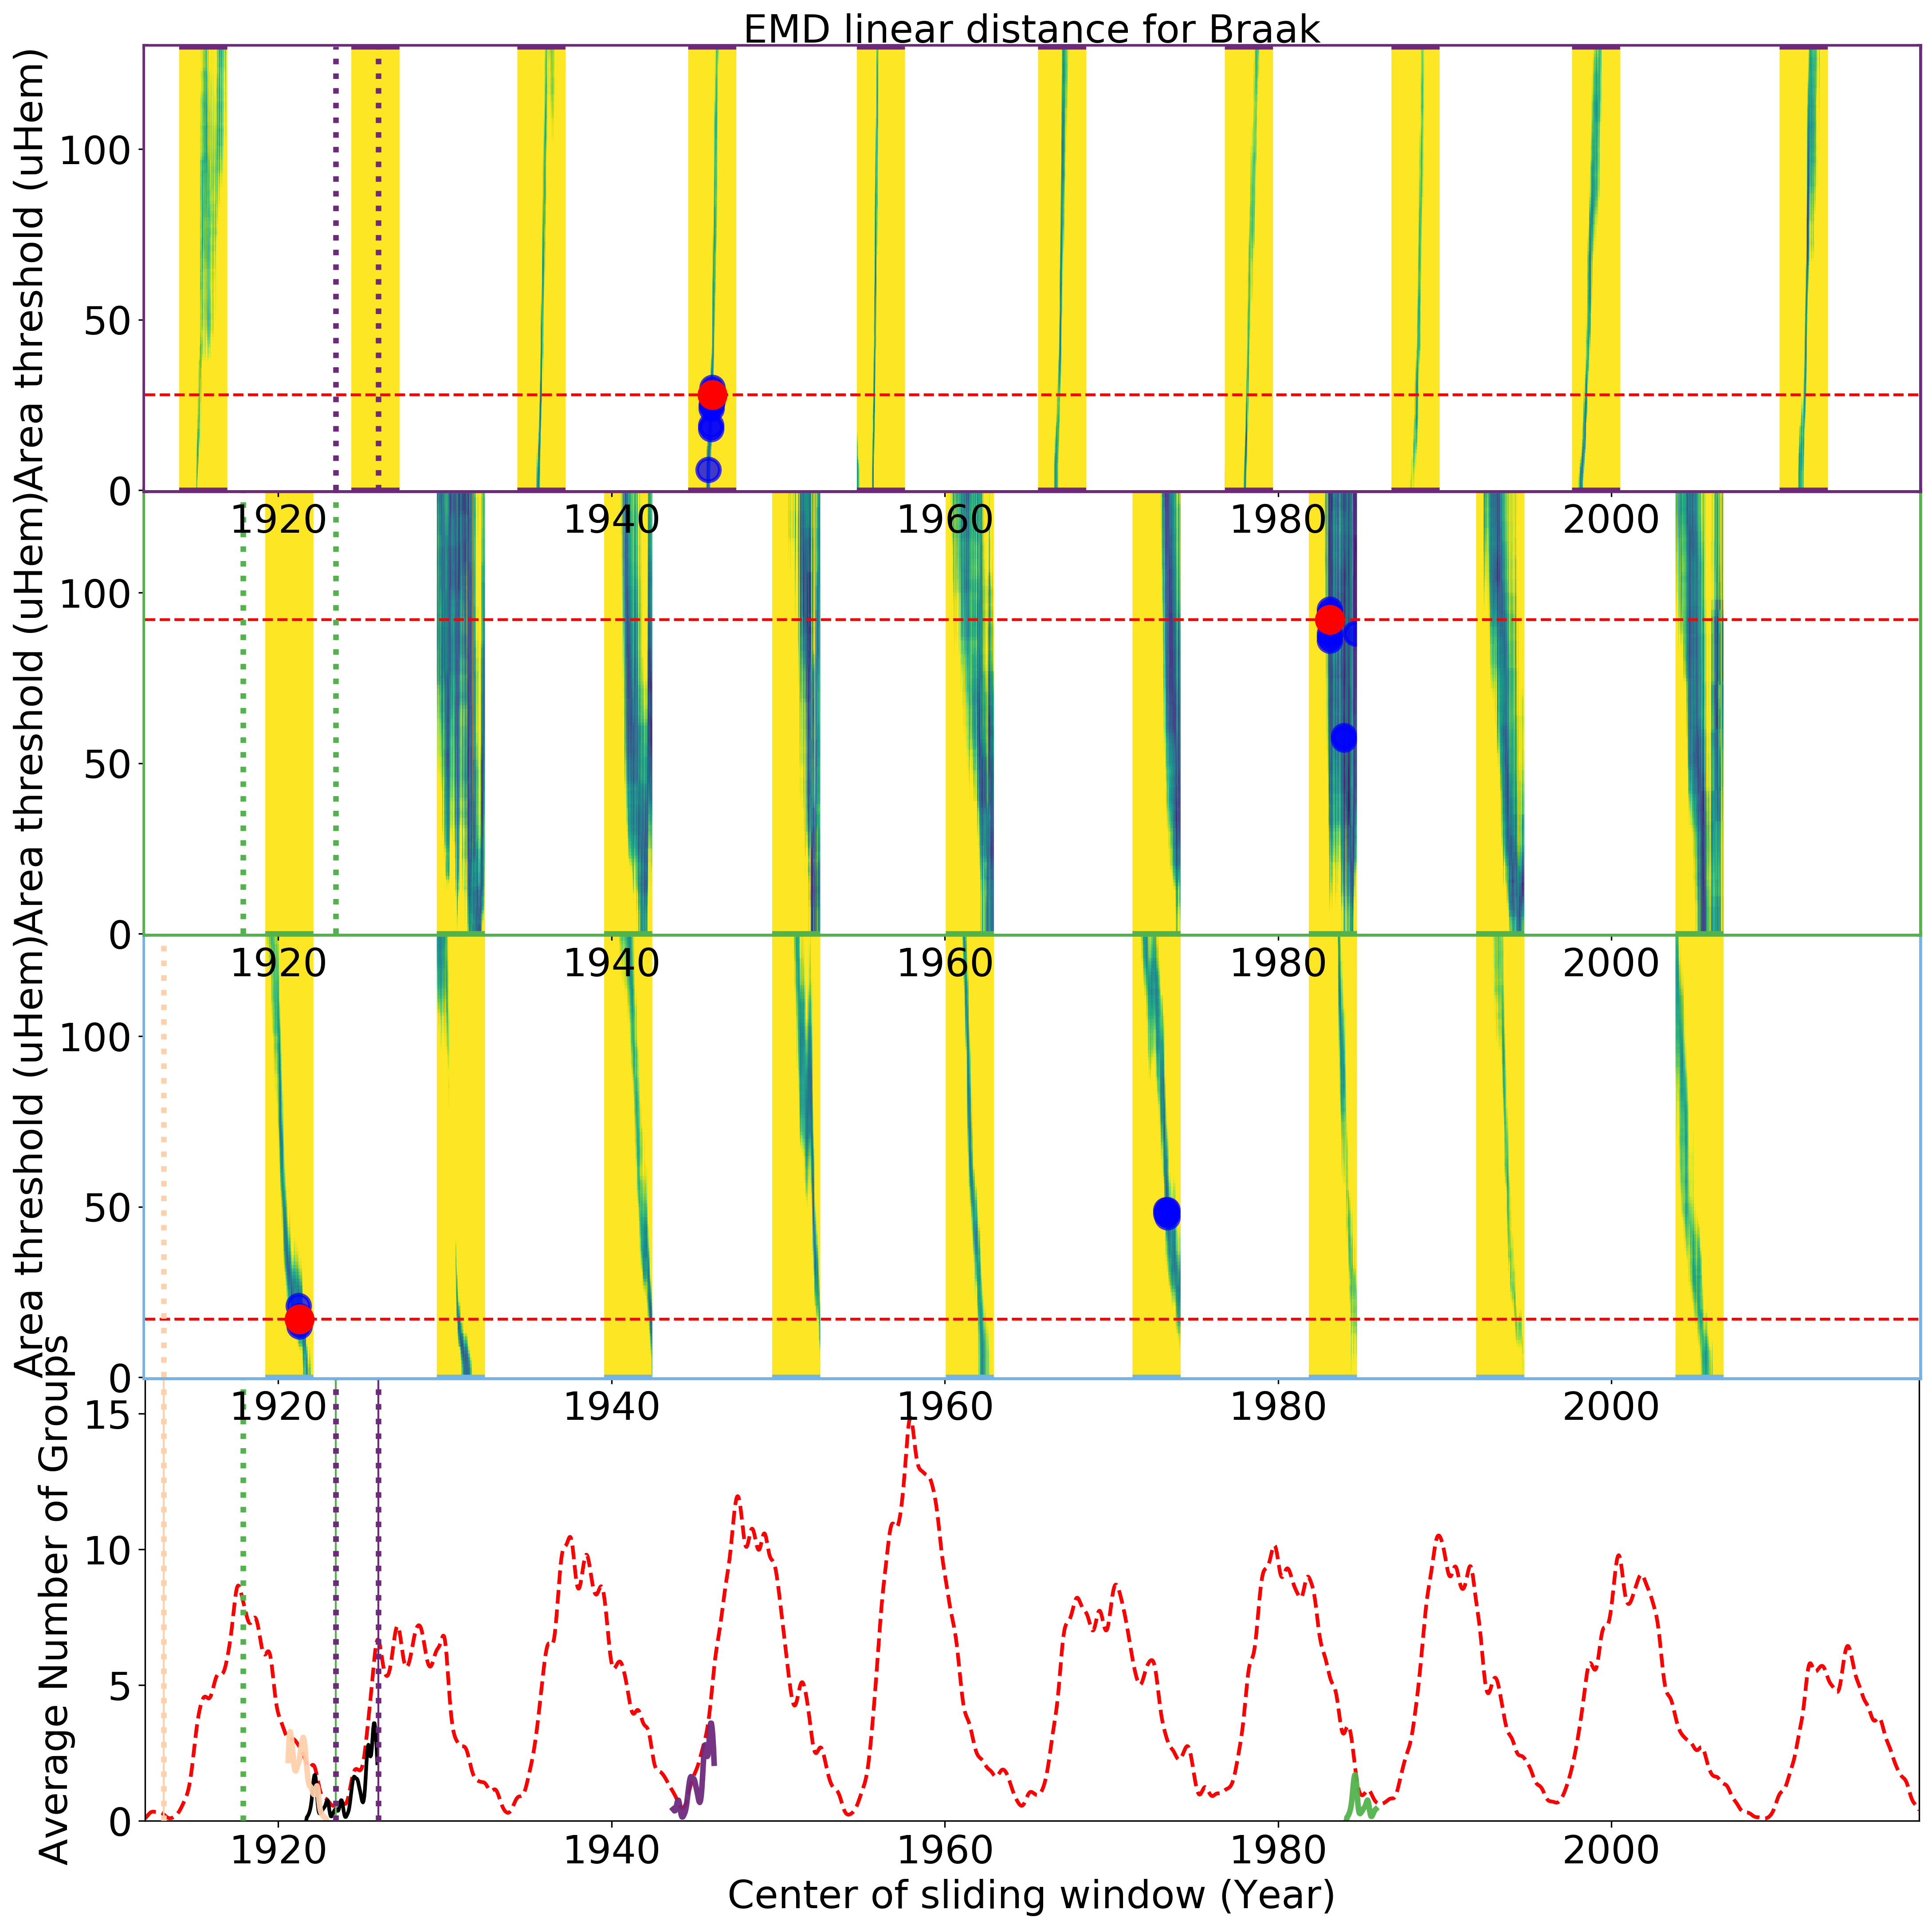

In [19]:
vmaxf = 2

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel

nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


pltx = (fyr1Ob+fyr2Ob)/2

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2)


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)

# EMD Pcolor
plt.viridis()

n=0

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    
    # Defining mask based on the interval type (rise or decay)
    if cenPoints[siInx, 1] > 0:
        cadMaskI = risMaskI
        cadMask  = risMaskP
    else:
        cadMaskI = decMaskI
        cadMask  = decMaskP
                
     # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'FRACYEAR'].values.copy()     
    TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'ORDINAL'].values.copy() 
    TObsSNd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'AVGSNd'].values.copy()     

    # Plot Matrix Only if the period is valid
    if vldIntr[siInx]:  
        
        # Creating axis
        ax1 = fig.add_axes([ppadh, ppadv + (n+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])
        n = n+1
            
            
        # Calculating mesh for plotting
        x = REF_Grp['FRACYEAR'].values[cadMaskI]
        y = np.array(Thresholds)
        xx, yy = np.meshgrid(x, y)             

        #Plotting Optimization Matrix
        mesh = ax1.pcolormesh(xx,yy,EMDGr[siInx], alpha = 1, linewidth = 2, vmin = minGrp, vmax = maxGrp)
           
        # Best point
        ax1.scatter(bestThGrp[siInx][0,0], bestThGrp[siInx][0,1], c = 'r',linewidths = 2, s = 200, zorder=11, alpha = 1)
        ax1.plot([np.min(REF_Dat['FRACYEAR']), np.max(REF_Dat['FRACYEAR'])], [bestThGrp[siInx][0,1], bestThGrp[siInx][0,1]], color = 'r', linestyle = '--', zorder=11 )
        
        ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx, 0]+bestThGrp[siInx][0,0]
                 , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                 , alpha = 0.95)        
        
        # Best 10 points
        if nBest >= 10:
            for i in range(1,10):
                ax1.scatter(bestThGrp[siInx][i,0], bestThGrp[siInx][i,1], c = 'b',linewidths = 2, s = 150, zorder=10, alpha = 0.75)
            
        # Masking Gaps
        pltMsk  = np.logical_not(cadMask)
        ax1.fill_between(REF_Grp['FRACYEAR'],  REF_Grp['FRACYEAR']*0, y2=REF_Grp['FRACYEAR']*0+thE, where=pltMsk, color = 'w', zorder=10)

    
        # Plotting edges
        ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
        ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

        ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
        ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
        ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])            
            
    # Axes properties
    ax1.set_ylabel('Area threshold (uHem)')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = thS, top = thE)
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

fig.savefig('testBoth/' + NamObs.capitalize() + '_EMD_1G.png', bbox_inches='tight', dpi = 103, pad_inches=0)


**FIGURE:** _Bottom:_ Reference average number of groups (red). True location of the observer groups (black).  Observer sub-intervals (vertical dotted lines).  Top-ten shifts with the best match between observer and reference ADFs (faint colored curves).  Each sub-interval is color coded.

_Top panels:_ Each panel shows the distance measured between observer and reference ADFs as a function of threshold and shift for a given sub-interval. The true location of the sub-interval is shown using colored vertical dotted lines.  The true shift is indicated by a vertical white dashed line.  The optimal threshold for the true interval is shown with a red dot.  The best 20 points are denoted by white circles (the smaller the distance, the larger the dot).  In the colormap, dark blue denotes a good match and bright yellow a bad match.  The color-scale is saturated at 6 times the minimum ADF distance. **Invalid intervals are blank.**

## Plotting distribution of Thresholds for each interval

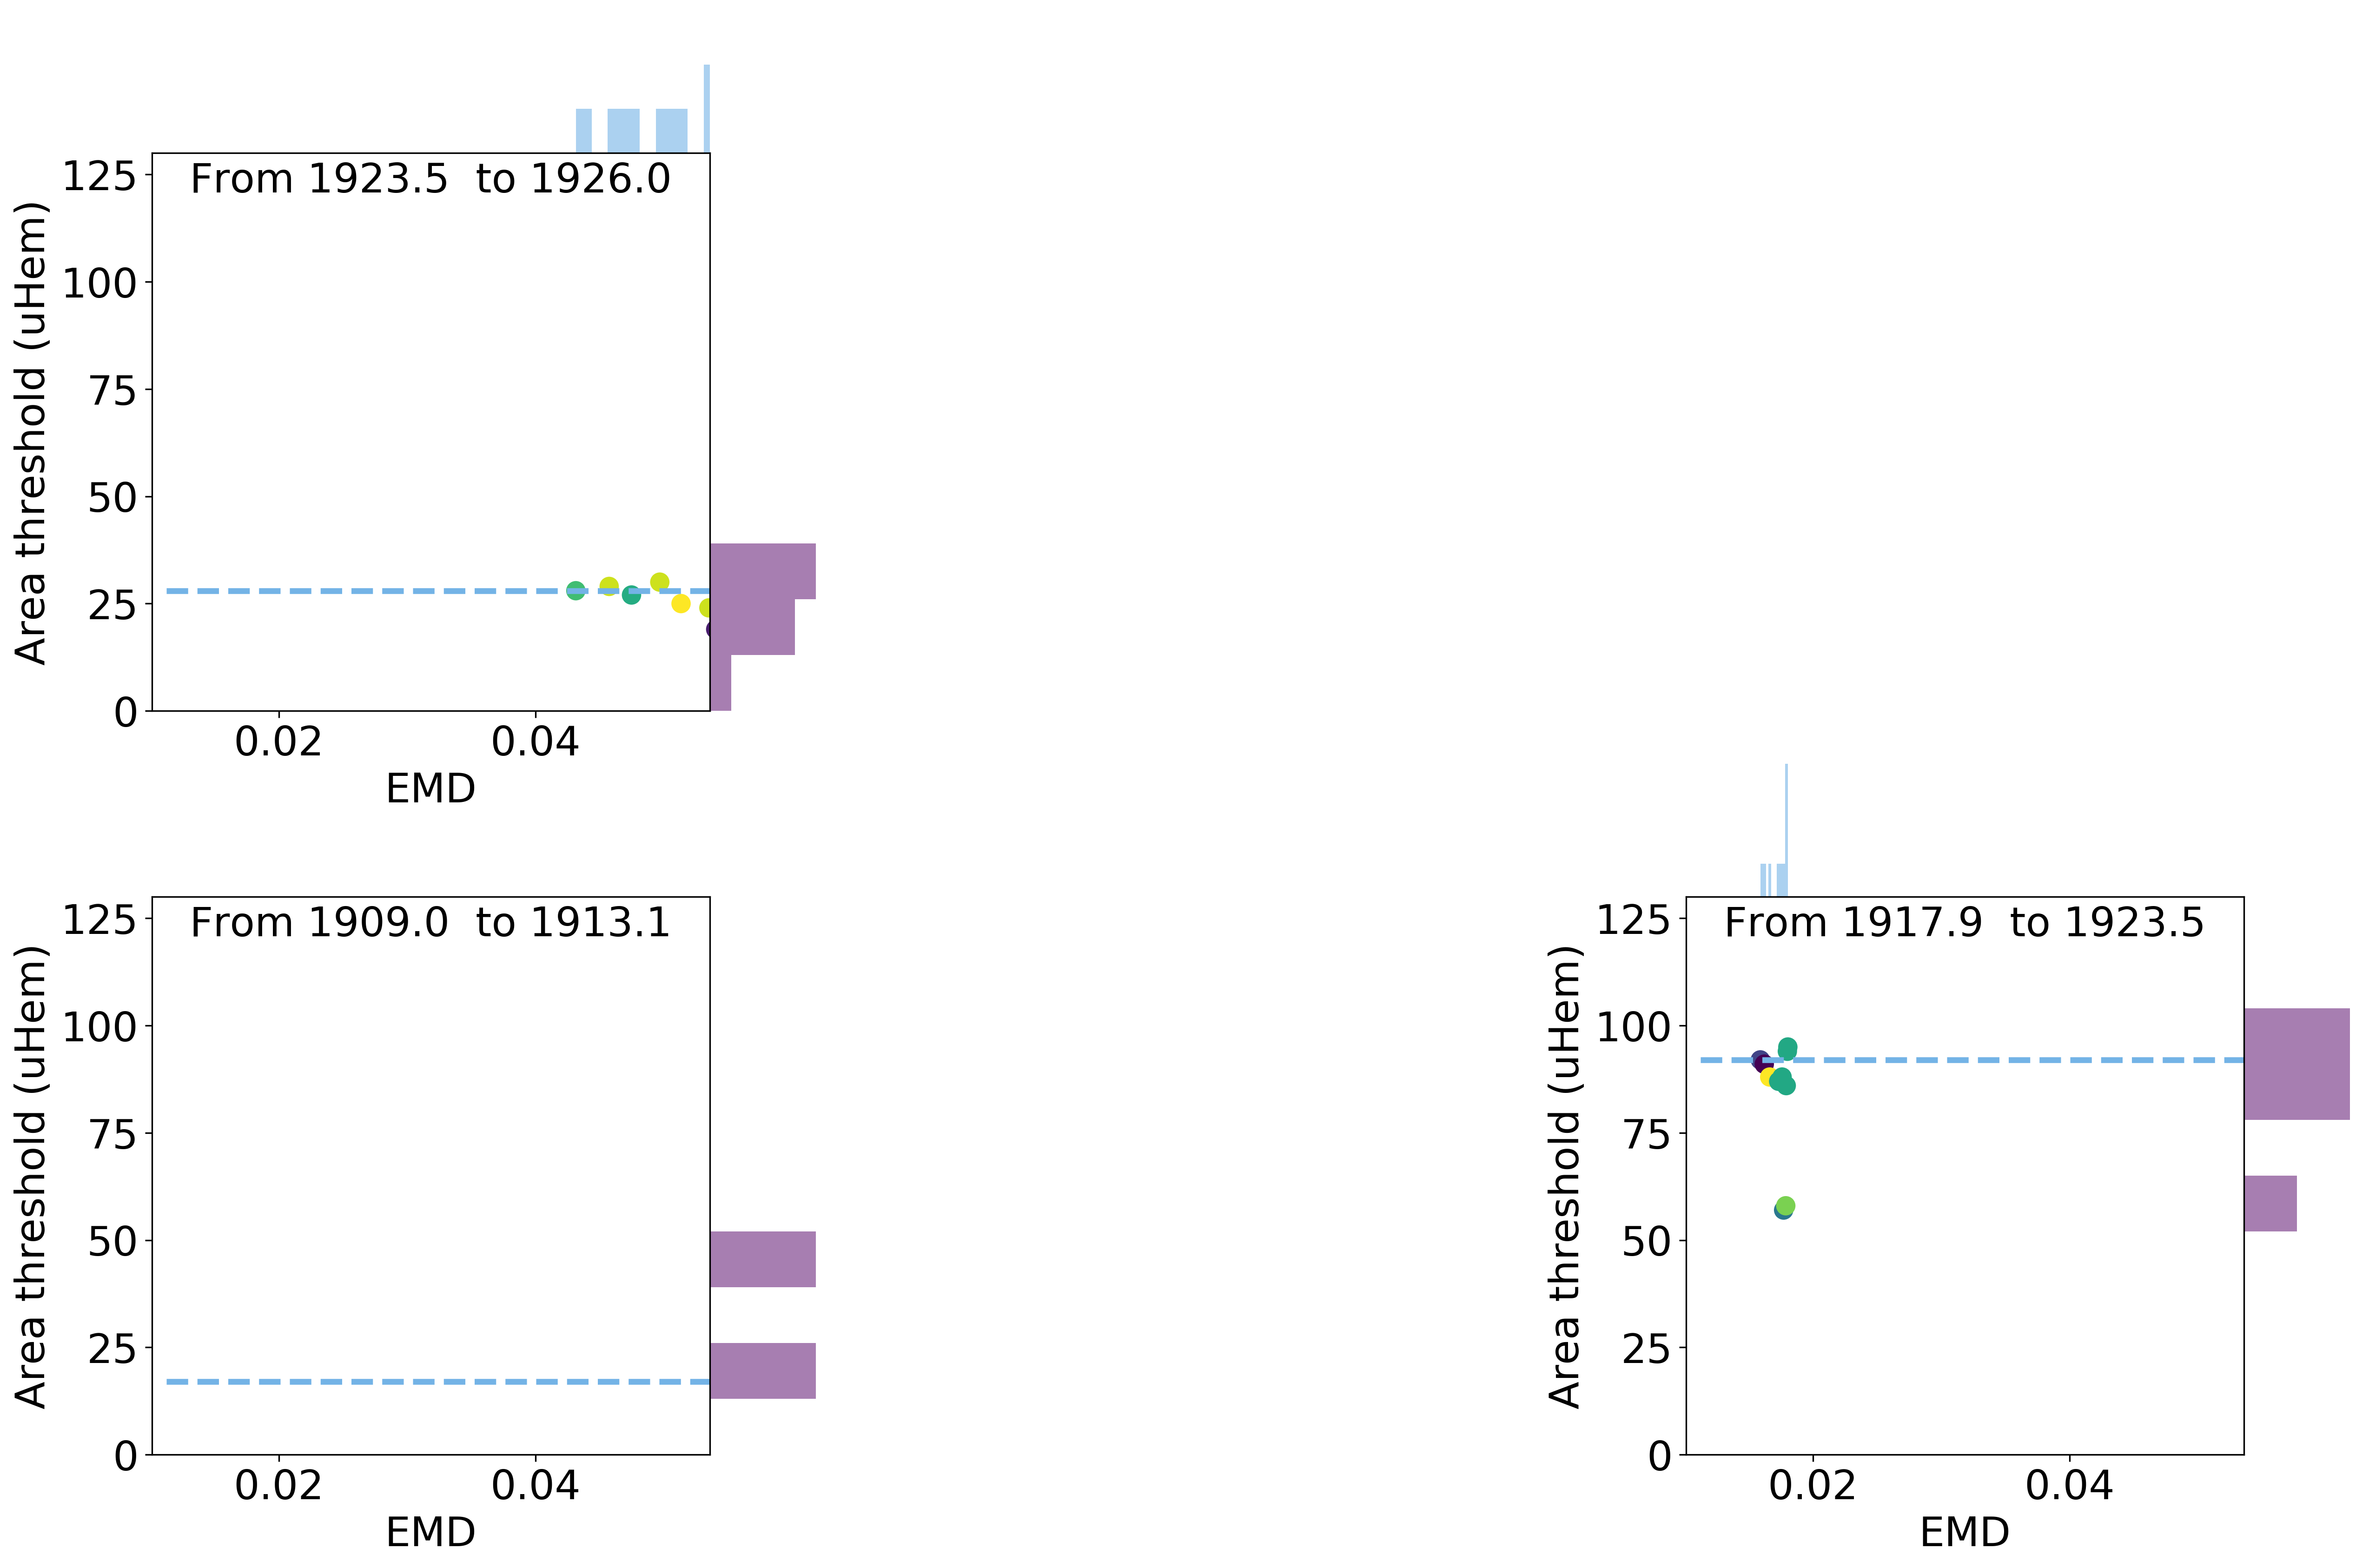

In [20]:
# Variables to store the mean threshold and its standard deviation
wAvI = vldIntr.copy()*0
wSDI = wAvI.copy()

bestTh = bestThGrp
minM = minGrp
maxM = maxGrp
emdi = 2
emdci = 4
maxF = 4

    
# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):

    # Perform analysis Only if the period is valid
    if vldIntr[siInx]:        

        wAvI[siInx] = bestThGrp[siInx][0,1]
        wSDI = np.nan
    
# Only plot if using more than one theshold
# if nBest == 1:

# Distribution Plots of EMD thresholds for different intervals
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = int(np.ceil(vldIntr.shape[0]/nph))      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 100  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 100 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units




## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
for i in range(0, nph):
    for j in range(0,npv):

        n = (nph*(j)+i)

        #Only add the panel if it exists 
        if n<vldIntr.shape[0]:

            # Plot only if the period is valid
            if vldIntr[n]:

                # Top Distribution
                axd = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) , ppadv + j*(pxy/fszv+ppadv2) + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)], label= 'a'+str(n))
                axd.hist(bestTh[n][:,emdi],  color=Clr[4], alpha=.6, density = True);

                # Axes properties
                axd.set_xlim(left = np.floor(np.min(bestTh[n][:,2])), right = np.ceil(np.max(bestTh[n][:,2])))
                axd.set_axis_off()


                # Right Distribution
                ax2 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) + pxx/fszh*frc, ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc*(1-frc), pxy/fszv*frc], label= 'b'+str(n))
                ax2.hist(bestTh[n][:,1], bins = np.arange(thS,thE+thI,(thE-thS)/np.sqrt(nBest)),  color=Clr[2], alpha=.6, orientation = 'horizontal', density = True);

                # # Axes properties
                ax2.set_ylim(bottom = 0, top = thE)
                ax2.set_axis_off()

                alpha = 1#alpha.astype(float)
                # Scatter Plot
                ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], sharex=axd, label= 'b'+str(n))
                ax1.scatter(bestTh[n][:,emdi], bestTh[n][:,1], c=bestTh[n][:,3], edgecolor="none", alpha = alpha, s=100, linewidths = 2)
                
                ax1.plot(np.array([minM, maxM]), np.array([1,1])*wAvI[n], '--'
                         , color = Clr[4], linewidth = 3)
#                 ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n]-wSDI[n], ':'
#                          , color = Clr[4], linewidth = 2)
#                 ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n]+wSDI[n], ':'
#                          , color = Clr[4], linewidth = 2)

                # Axes properties
                ax1.set_ylabel('Area threshold (uHem)')
                ax1.set_xlabel('EMD')
                ax1.text(0.5, 0.95,'From ' + str(np.round(endPoints[n, 0],decimals=1)) + '  to ' + str(np.round(endPoints[n+1, 0],decimals=1)) , horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)
                ax1.set_xlim(left = minM*0.9, right = maxM/maxF)
                ax1.set_ylim(bottom = 0, top = thE);
                
fig.savefig(NamObs.capitalize() + '_Dis_int.png', bbox_inches='tight', dpi = 103, pad_inches=0)                

**FIGURE:** Each panel shows a scatterplot of the optimal EMD distance vs. optimal thresholds, as well as their marginal distributions for each valid interval separately.   The thick blue line shows the average threshold weighted by distance and the thin blue lines show its weighted standard deviation. **Invalid intervals are blank.**

<a id='#scatterPlots'></a>
## Scatterplot of Overlapping Reference and Calibrated days using only days during valid intervals

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


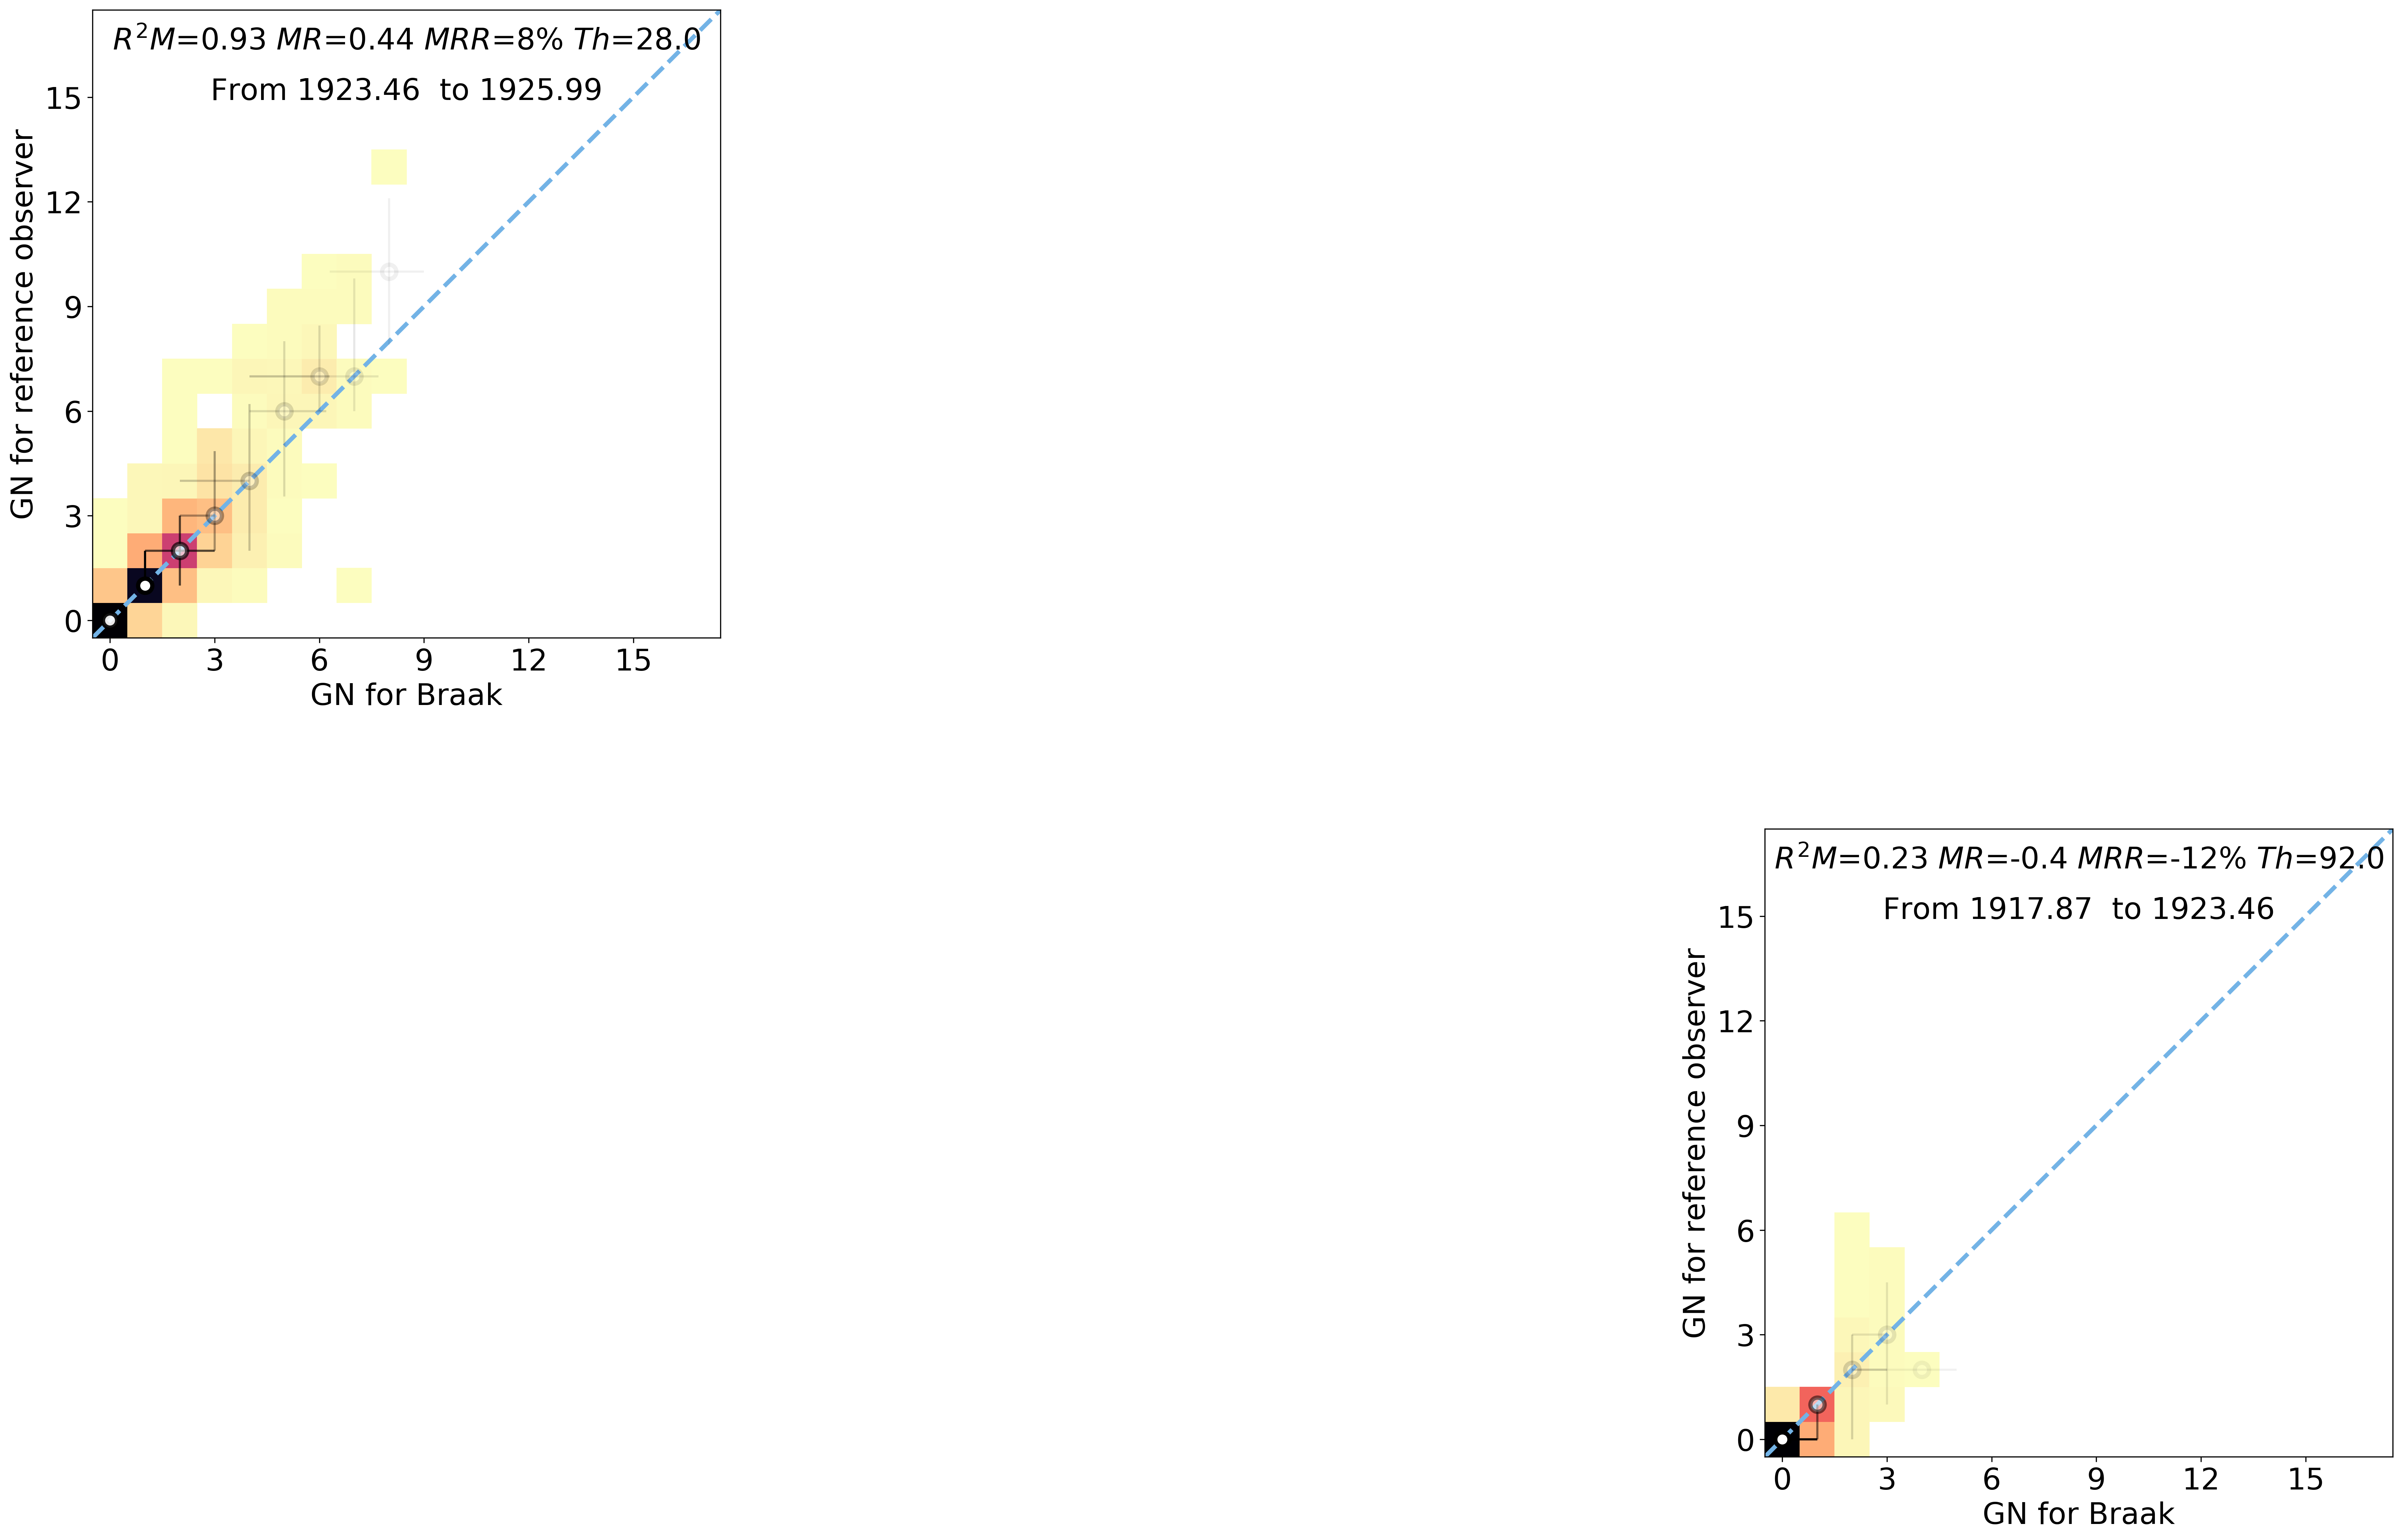

In [26]:
#Flag that activates sqrt(GN + 1)
SqrtF = False

calRef = np.array([0])
calObs = np.array([0])


# Size definitions
dpi = 300
pxx = 2300   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = int(np.ceil(vldIntr.shape[0]/nph))      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 100  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 100 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Calculating maximum for plotting
maxNPlt = 0
# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    # Perform analysis Only if the period is valid
    if vldIntr[siInx] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[siInx, 0],REF_Dat['FRACYEAR']<endPoints[siInx+1, 0]))>0:
        TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
        TObsREFDat = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAvI[siInx]) ,axis = 1).astype(float)
        TObsREFDat = TObsREFDat[np.logical_and(REF_Dat['FRACYEAR']>=endPoints[siInx, 0],REF_Dat['FRACYEAR']<endPoints[siInx+1, 0])].copy()
        maxNPlt = np.max([np.nanmax(TObsREFDat),np.nanmax(TObsDat), maxNPlt])



for i in range(0, nph):
    for j in range(0,npv):
                
        n = (nph*(j)+i)
        
        #Only add the panel if it exists 
        if n<vldIntr.shape[0]:

            # Plot only if the period is valid and has overlap
            if vldIntr[n] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[n, 0],REF_Dat['FRACYEAR']<endPoints[n+1, 0]))>0:
                
                # Calculating number of groups in reference data for given threshold
                grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],wAvI[n]) ,axis = 1).astype(float)
                grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

                # Selecting observer's interval
                TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                     ,'GROUPS'].values.copy()
                TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                     ,'ORDINAL'].values.copy()
                                
                # Selecting the days of overlap with calibrated observer
                grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
                grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]

                # Removing NaNs    
                grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
                grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

                grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
                grpsREFw = grpsREFw[np.isfinite(grpsREFw)]


                # Appending to calibrated arrays?
                calRef = np.append(calRef,grpsREFw)
                calObs = np.append(calObs,grpsObsw)
                
                if (np.sum(grpsREFw)) and np.sum(grpsObsw):

                    # Average group number 
                    ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))

                    plotHistSqrtSSN(ax1, grpsREFw, grpsObsw, np.round(wAvI[n],decimals=1), maxNPlt, SqrtF)

                    ax1.text(0.5, 0.87,'From ' + str(np.round(endPoints[n, 0],decimals=2)) + '  to ' + str(np.round(endPoints[n+1, 0],decimals=2)) , horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)

**FIGURE:** Each panel shows a scatterplot of the Observer vs. the reference after applying the optimal threshold obtained in the step above.  Each valid interval is done separately and only if it has overlap with the reference.  Behind the scatterplot is show a color 2D histogram showing the number of points in each block.  The faint dots also indicate less counts.  **Invalid intervals are blank.**



# Simultaneous Optimization of Thresholds for All Sub-Intervals

The reason behind the division of the observer in sub-intervals is to allow for sequences combining cycles of various strengths that may have been observed outside the reference period, but not in the last 100 years.  However, fitting each sub-interval separately suffers from reduced statistics.  To address that, we perform simultaneous fits for all sub-interval by specifying a threshold, but letting each sub-interval's shift be freely optimized.  

<a id='#disThres'></a>
## Calculating the minimum distance for each sub-interval and each shift to identify shifts we could ignore

Using combinations of all possible shifts results in a large, unmanageable, amount of possibilities.  For this reason, for each sub-interval we limit the search to their best shifts defined using the minimum distance for each shift including all thresholds and capped at _disThres_ times the best distance for each sub-interval (see below)  

**FIGURE:** _Bottom:_ Reference average number of groups (red). True location of the observer groups (black).  Observer sub-intervals (vertical dotted lines).  

_Top panels:_ Each panel shows the smallest EMD distance of all possible thresholds for a given window shift.  The dotted blue lines indicate the upper threshold used to to determine the possible shifts that will be combined in the simultaneous fit.  Invalid intervals are blank.

## Defining Functions to Iterate Over All Possible Combinations

In [27]:
from copy import copy

def mrange(min_values, max_values=None):
    '''
        Inputs: min_values, a list/tuple with the starting values
                    if not given, assumed to be zero
                max_values: a list/tuple with the ending values
        outputs: a tuple of values
    '''
    
    if not max_values:
        max_values = min_values
        min_values = [0 for i in max_values]
    indices_list = copy(min_values)

    #Yield the (0,0, ..,0) value
    yield tuple(indices_list)
    
    while(True):
        indices_list = updateIndices(indices_list, min_values, max_values)
        if indices_list:
            yield tuple(indices_list)
        else:
            break#We're back at the beginning
   
def updateIndices(indices_list, min_values, max_values):
    '''
        Update the list of indices
    '''
    for index in range(len(indices_list)-1, -1, -1):
        
        #If the indices equals the max values, the reset it and 
        #move onto the next value
        if not indices_list[index] == max_values[index] - 1:
            indices_list[index] += 1
            return indices_list
        else:
            indices_list[index] = min_values[index]
    return False

## Doing simultaneous fits with one optimal per cycle

In [28]:
nBestMul = 100
EMDD = EMDGr.copy()

# Allocating variable to store top matches
EMDComb = np.ones((cenPoints.shape[0] + 4 + NGrpsBins*2,nBestMul))*10000

# Identify first valid index
fstVldIn = vldIntr.nonzero()[0][0]

# Going through different thresholds
for TIdx, Thr in enumerate(Thresholds):
# for TIdx in range(0,1):

    # Dictionary that will store valid shift indices for each sub-interval
    valShfInx = []

    # Dictionary that will store the length of the index array for each sub-interval
    valShfLen = []

    # Going through different sub-intervals
    for siInx in range(0,cenPoints.shape[0]):

        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0:
            cadMaskI = risMaskI
            cadMask  = risMaskP
        else:
            cadMaskI = decMaskI
            cadMask  = decMaskP         

        # Process only if period is valid
        if vldIntr[siInx]:
                        
            # Calculating minimum distance for plotting
            x = REF_Grp['FRACYEAR'].values[cadMaskI]
            yGrp = EMDGr[siInx][TIdx,:]
            
            bestCycIn = np.array([])
            # Finding best shift for each cycle
            for ceni, cen in enumerate(cenPointsR):
                
                # Add index if there is no overlap and is the right kind of interval
                ObsOvr = np.logical_and(cenPoints[siInx][0]>=endPointsR[ceni, 0], cenPoints[siInx][0]<=endPointsR[ceni+1, 0])               
                if (cen[1] == cenPoints[siInx, 1]) and ( (not ObsOvr) or (not noOvrlpSw) ): 
                    
                    bestEMD = np.min(yGrp[np.logical_and(x>=cen[0]-phTol, x<=cen[0]+phTol)])
                    bestin = np.logical_and(yGrp==bestEMD, np.logical_and(x>=cen[0]-phTol, x<=cen[0]+phTol)).nonzero()[0][0]
#                     bestCycIn = np.append(bestCycIn,np.array([bestin-1,bestin,bestin+1]))
                    bestCycIn = np.append(bestCycIn,bestin)

            bestCycIn = bestCycIn.astype(int)
            bestCycIn = np.unique(bestCycIn)
            
            # Appending valid indices to variable and storing length
            valShfInx.append(bestCycIn.astype(int))
            valShfLen.append(bestCycIn.shape[0])

        # If period is not valid append ones so that they don't add to the permutations
        else:
            valShfInx.append(1)
            valShfLen.append(1)

    # Saving lengths as array
    valShfLen = np.array(valShfLen)

    print('Threshold ', Thr  ,' - Number of valid combinations:', np.nanprod(valShfLen))
    print(valShfLen)#, valShfInx)
    
#     print('start', datetime.datetime.now())    
    
    comProg = 0
    for comb in mrange(valShfLen):
           
        GrpObsI = np.zeros((NGrpsBins))
        GrpREFI = np.zeros((NGrpsBins))
        
        NGrpObs = 0
        NGrpREF = 0
        maxDifN = 0
        
        # Joining ADF from all sub-interval for the specified shifts
        nval = 0
        for siInx in range(0,cenPoints.shape[0]):
            
            # Append only if period is valid
            if vldIntr[siInx]:
                nval = nval+1
                
                GrpObsI += grpDirObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]
                GrpREFI += grpDirREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]
                
                NGrpObs += grpNObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]]]
                NGrpREF += grpNREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]]]
                RelDiff = np.abs(grpNObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]]] - grpNREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]]] )/grpNObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]]]
                maxDifN = np.max([maxDifN, RelDiff])

        GrpObsI /= nval
        GrpREFI /= nval
        tmpEMD = emd(GrpREFI.astype(np.float64),GrpObsI.astype(np.float64),DisG.astype(np.float64))
        
        if np.any(EMDComb[0,:]>tmpEMD):            
            
            # Initializing array to be inserted
            insArr = [tmpEMD, Thr, np.abs(NGrpObs-NGrpREF)/NGrpObs, maxDifN]

            # Append shifts
            for siInx in range(0, cenPoints.shape[0]):

                # Append only if period is valid
                if vldIntr[siInx]:
                    insArr.append(valShfInx[siInx][comb[siInx]])
                # If not, append dummy
                else:
                    insArr.append(np.nan)

            # Convert to numpy array
            insArr = np.array(insArr)
            
            insArr = np.append(insArr, GrpObsI)
            insArr = np.append(insArr, GrpREFI)

            # Determining index for insertion
            insInx = nBestMul - np.sum(EMDComb[0, :] >= tmpEMD)

            # Insert values
            EMDComb = np.insert(EMDComb, insInx, insArr, axis=1)

            # Remove last element
            EMDComb = EMDComb[:, 0:nBestMul]
    
    # Inform user of progress
#     print('End: ', datetime.datetime.now()) 


Threshold  0  - Number of valid combinations: 648
[9 1 8 9]
Threshold  1  - Number of valid combinations: 648
[9 1 8 9]
Threshold  2  - Number of valid combinations: 648
[9 1 8 9]
Threshold  3  - Number of valid combinations: 648
[9 1 8 9]
Threshold  4  - Number of valid combinations: 648
[9 1 8 9]
Threshold  5  - Number of valid combinations: 648
[9 1 8 9]
Threshold  6  - Number of valid combinations: 648
[9 1 8 9]
Threshold  7  - Number of valid combinations: 648
[9 1 8 9]
Threshold  8  - Number of valid combinations: 648
[9 1 8 9]
Threshold  9  - Number of valid combinations: 648
[9 1 8 9]
Threshold  10  - Number of valid combinations: 648
[9 1 8 9]
Threshold  11  - Number of valid combinations: 648
[9 1 8 9]
Threshold  12  - Number of valid combinations: 648
[9 1 8 9]
Threshold  13  - Number of valid combinations: 648
[9 1 8 9]
Threshold  14  - Number of valid combinations: 648
[9 1 8 9]
Threshold  15  - Number of valid combinations: 648
[9 1 8 9]
Threshold  16  - Number of valid c

In [29]:
strmd = EMDComb.copy()

In [30]:
EMDComb = strmd.copy()

I = np.argsort(EMDComb[3,:],axis = 0)
tmOpMat = np.squeeze(EMDComb[:,I])
tmOpMat = tmOpMat[:, 0:nBest2]
I = np.argsort(tmOpMat[0,:],axis = 0)
tmOpMat = np.squeeze(tmOpMat[:,I])

np.transpose(tmOpMat[[0,1,2,3],:])
EMDComb = tmOpMat.copy()

In [31]:
np.transpose(EMDComb[:,EMDComb[2,:]<1])[:,[0,1,2,3]]

array([[8.36203371e-03, 7.00000000e+01, 5.44280443e-02, 1.26760563e-01],
       [1.39810836e-02, 4.00000000e+00, 2.67774700e-02, 4.08602151e-02],
       [1.47130327e-02, 7.60000000e+01, 6.91881919e-02, 1.19747899e-01],
       [1.53051071e-02, 7.70000000e+01, 7.10332103e-02, 1.21848739e-01],
       [1.57770356e-02, 7.40000000e+01, 4.24354244e-02, 2.46478873e-01],
       [1.62511138e-02, 6.80000000e+01, 5.53505535e-03, 1.33802817e-01],
       [1.63560436e-02, 7.50000000e+01, 4.52029520e-02, 2.39436620e-01],
       [1.63951148e-02, 7.80000000e+01, 7.28782288e-02, 1.23949580e-01],
       [1.65121150e-02, 7.50000000e+01, 4.88929889e-02, 2.39436620e-01],
       [1.69800559e-02, 6.00000000e+00, 2.02952030e-02, 1.76470588e-01]])

[8.36203371e-03 7.00000000e+01 5.44280443e-02 1.26760563e-01
 8.33000000e+02            nan 1.02100000e+03 2.09800000e+03
 4.96148396e-01 2.62508909e-01 1.23602339e-01 5.62148876e-02
 2.47652709e-02 2.26193482e-02 1.20249817e-02 2.11586781e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.96623071e-01 2.59325715e-01
 1.25788111e-01 5.64746843e-02 2.62846364e-02 2.07684820e-02
 1.16170855e-02 1.57604413e-03 1.54216988e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

<BarContainer object of 30 artists>

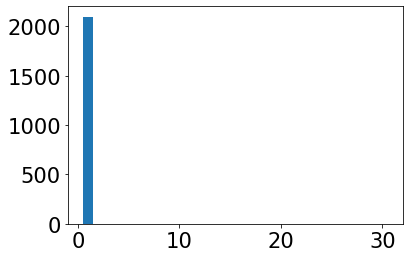

In [32]:
index = 0
print(EMDComb[:,index])


plt.bar((np.arange(1,NGrpsBins+1)), EMDComb[cenPoints.shape[0] + 3:cenPoints.shape[0] + 3 + NGrpsBins,index], width=1)
plt.bar((np.arange(1,NGrpsBins+1)), EMDComb[cenPoints.shape[0] + 3 + NGrpsBins:cenPoints.shape[0] + 3 + 2*NGrpsBins,index], width=1, alpha=0.5)
# EMDComb[cenPoints.shape[0] + 2 + MoLngt+1:cenPoints.shape[0] + 2 + 2*MoLngt+2,1]

## Doing simultaneous fitting of all intervals by prescribing a common threshold but allowing for any combination of shifts

In order to keep memory requirements manageable we only keep the top _nBestMul_ matches. 

In [33]:
# nBestMul = 100

# # distance between observer and reference ADFs for each sub-interval separately)
# disThres = 1.5

# # Allocating variable to store top matches
# EMDComb = np.ones((cenPoints.shape[0]+2,nBestMul))*10000

# # Identify first valid index
# fstVldIn = vldIntr.nonzero()[0][0]

# # Going through different thresholds
# for TIdx, Thr in enumerate(Thresholds):
# # for TIdx in range(0,1):

#     # Dictionary that will store valid shift indices for each sub-interval
#     valShfInx = []

#     # Dictionary that will store the length of the index array for each sub-interval
#     valShfLen = []

#     # Going through different sub-intervals
#     for siInx in range(0,cenPoints.shape[0]):

#         # Defining mask based on the interval type (rise or decay)
#         if cenPoints[siInx, 1] > 0:
#             cadMaskI = risMaskI
#             cadMask  = risMaskP
#         else:
#             cadMaskI = decMaskI
#             cadMask  = decMaskP

#         # If we want to ignore overlaps    
#         if noOvrlpSw:
#             Ovrlp = np.array(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[siInx, 0],REF_Dat['FRACYEAR']<endPoints[siInx+1, 0]).nonzero()[0])            
#             cadMaskI = np.setdiff1d(cadMaskI, Ovrlp)          

#         # Process only if period is valid
#         if vldIntr[siInx]:           

#             # Calculating minimum distance for plotting
#             x = REF_Grp['FRACYEAR'].values[cadMaskI]
#             y = EMDD[siInx][TIdx,:]

#             # Appending valid indices to variable and storing length
#             valShfInx.append((y<=disThres*np.min(y)).nonzero()[0])
#             valShfLen.append(valShfInx[siInx].shape[0])

#         # If period is not valid append ones so that they don't add to the permutations
#         else:
#             valShfInx.append(1)
#             valShfLen.append(1)

#     # Saving lengths as array
#     valShfLen = np.array(valShfLen)

#     print('Threshold ', Thr  ,' - Number of valid combinations:', np.nanprod(valShfLen))
#     print(valShfLen)
    
# #     print('start', datetime.datetime.now())    
    
#     comProg = 0
#     for comb in mrange(valShfLen):
           
#         # Initializing arrays for joining the ADFs of all sub-intervals
#         ADFObsI = np.array([])
#         ADFREFI = np.array([])
        
#         # Joining ADF from all sub-interval for the specified shifts
#         for siInx in range(0,cenPoints.shape[0]):
            
#             # Append only if period is valid
#             if vldIntr[siInx]: 
                                
#                 # Numerator and denominator for given observer
#                 numADObsII = GDObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
#                 numQDObsII = MoLngt - QDObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD] 
#                 denFMObsII = GDObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]*0 + MoLngt
#                 denODObsII = ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
#                 # Numerator and denominator for reference
#                 numADREFII = GDREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
#                 numQDREFII = MoLngt - QDREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
#                 denFMREFII = GDREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]*0 + MoLngt
#                 denODREFII = ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD] 

#                 #defining solar activity level                            
#                 MMObsII=np.logical_and((SNdObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]>lowth), (SNdObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]<highth))
#                 MMREFII=np.logical_and((SNdREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]>lowth), (SNdREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]<highth))

#                 HMObsII=(SNdObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]>=highth)
#                 HMREFII=(SNdREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]>=highth)  
                    
#                 # Default numerators and denominators
#                 numObsII = numADObsII
#                 numREFII = numADREFII
#                 denObsII = denFMObsII
#                 denREFII = denFMREFII
                                                              
                                
#                 numObsII[HMObsII] = numQDObsII[HMObsII]
#                 numREFII[HMREFII] = numQDREFII[HMREFII]
                                
#                 denObsII[MMObsII] = denODObsII[MMObsII]
#                 denREFII[MMREFII] = denODREFII[MMREFII]
                    
#                 # ADF calculations
#                 ADF_Obs_fracII  = np.divide(numObsII, denObsII)
#                 ADF_REF_fracII  = np.divide(numREFII, denREFII)                
                
#                 # If it is the first interval re-create the arrays
#                 if ADFObsI.shape[0] == 0:                
#                     ADFObsI = ADF_Obs_fracII
                    
#                     ADFREFI = ADF_REF_fracII
            
#                 # If not, append ADF from all sub-interval for the specified shifts
#                 else:                    
#                     ADFObsI = np.append(ADFObsI,ADF_Obs_fracII)                                   
                    
#                     ADFREFI = np.append(ADFREFI, ADF_REF_fracII)                
                                
#         # Calculating Earth Mover's Distance
#         ADFObs, bins = np.histogram(ADFObsI, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
#         ADFREF, bins = np.histogram(ADFREFI, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
#         tmpEMD = emd(ADFREF.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64))
        
#         if np.any(EMDComb[0,:]>tmpEMD):            
            
#             # Initializing array to be inserted
#             insArr = [tmpEMD, Thr]

#             # Append shifts
#             for siInx in range(0, cenPoints.shape[0]):

#                 # Append only if period is valid
#                 if vldIntr[siInx]:
#                     insArr.append(valShfInx[siInx][comb[siInx]])
#                 # If not, append dummy
#                 else:
#                     insArr.append(np.nan)

#             # Convert to numpy array
#             insArr = np.array(insArr)

#             # Determining index for insertion
#             insInx = nBestMul - np.sum(EMDComb[0, :] >= tmpEMD)

#             # Insert values
#             EMDComb = np.insert(EMDComb, insInx, insArr, axis=1)

#             # Remove last element
#             EMDComb = EMDComb[:, 0:nBestMul]
    
#     # Inform user of progress
# #     print('End: ', datetime.datetime.now()) 


## Plot Location and Threshold of Best Matches

(68, 10)


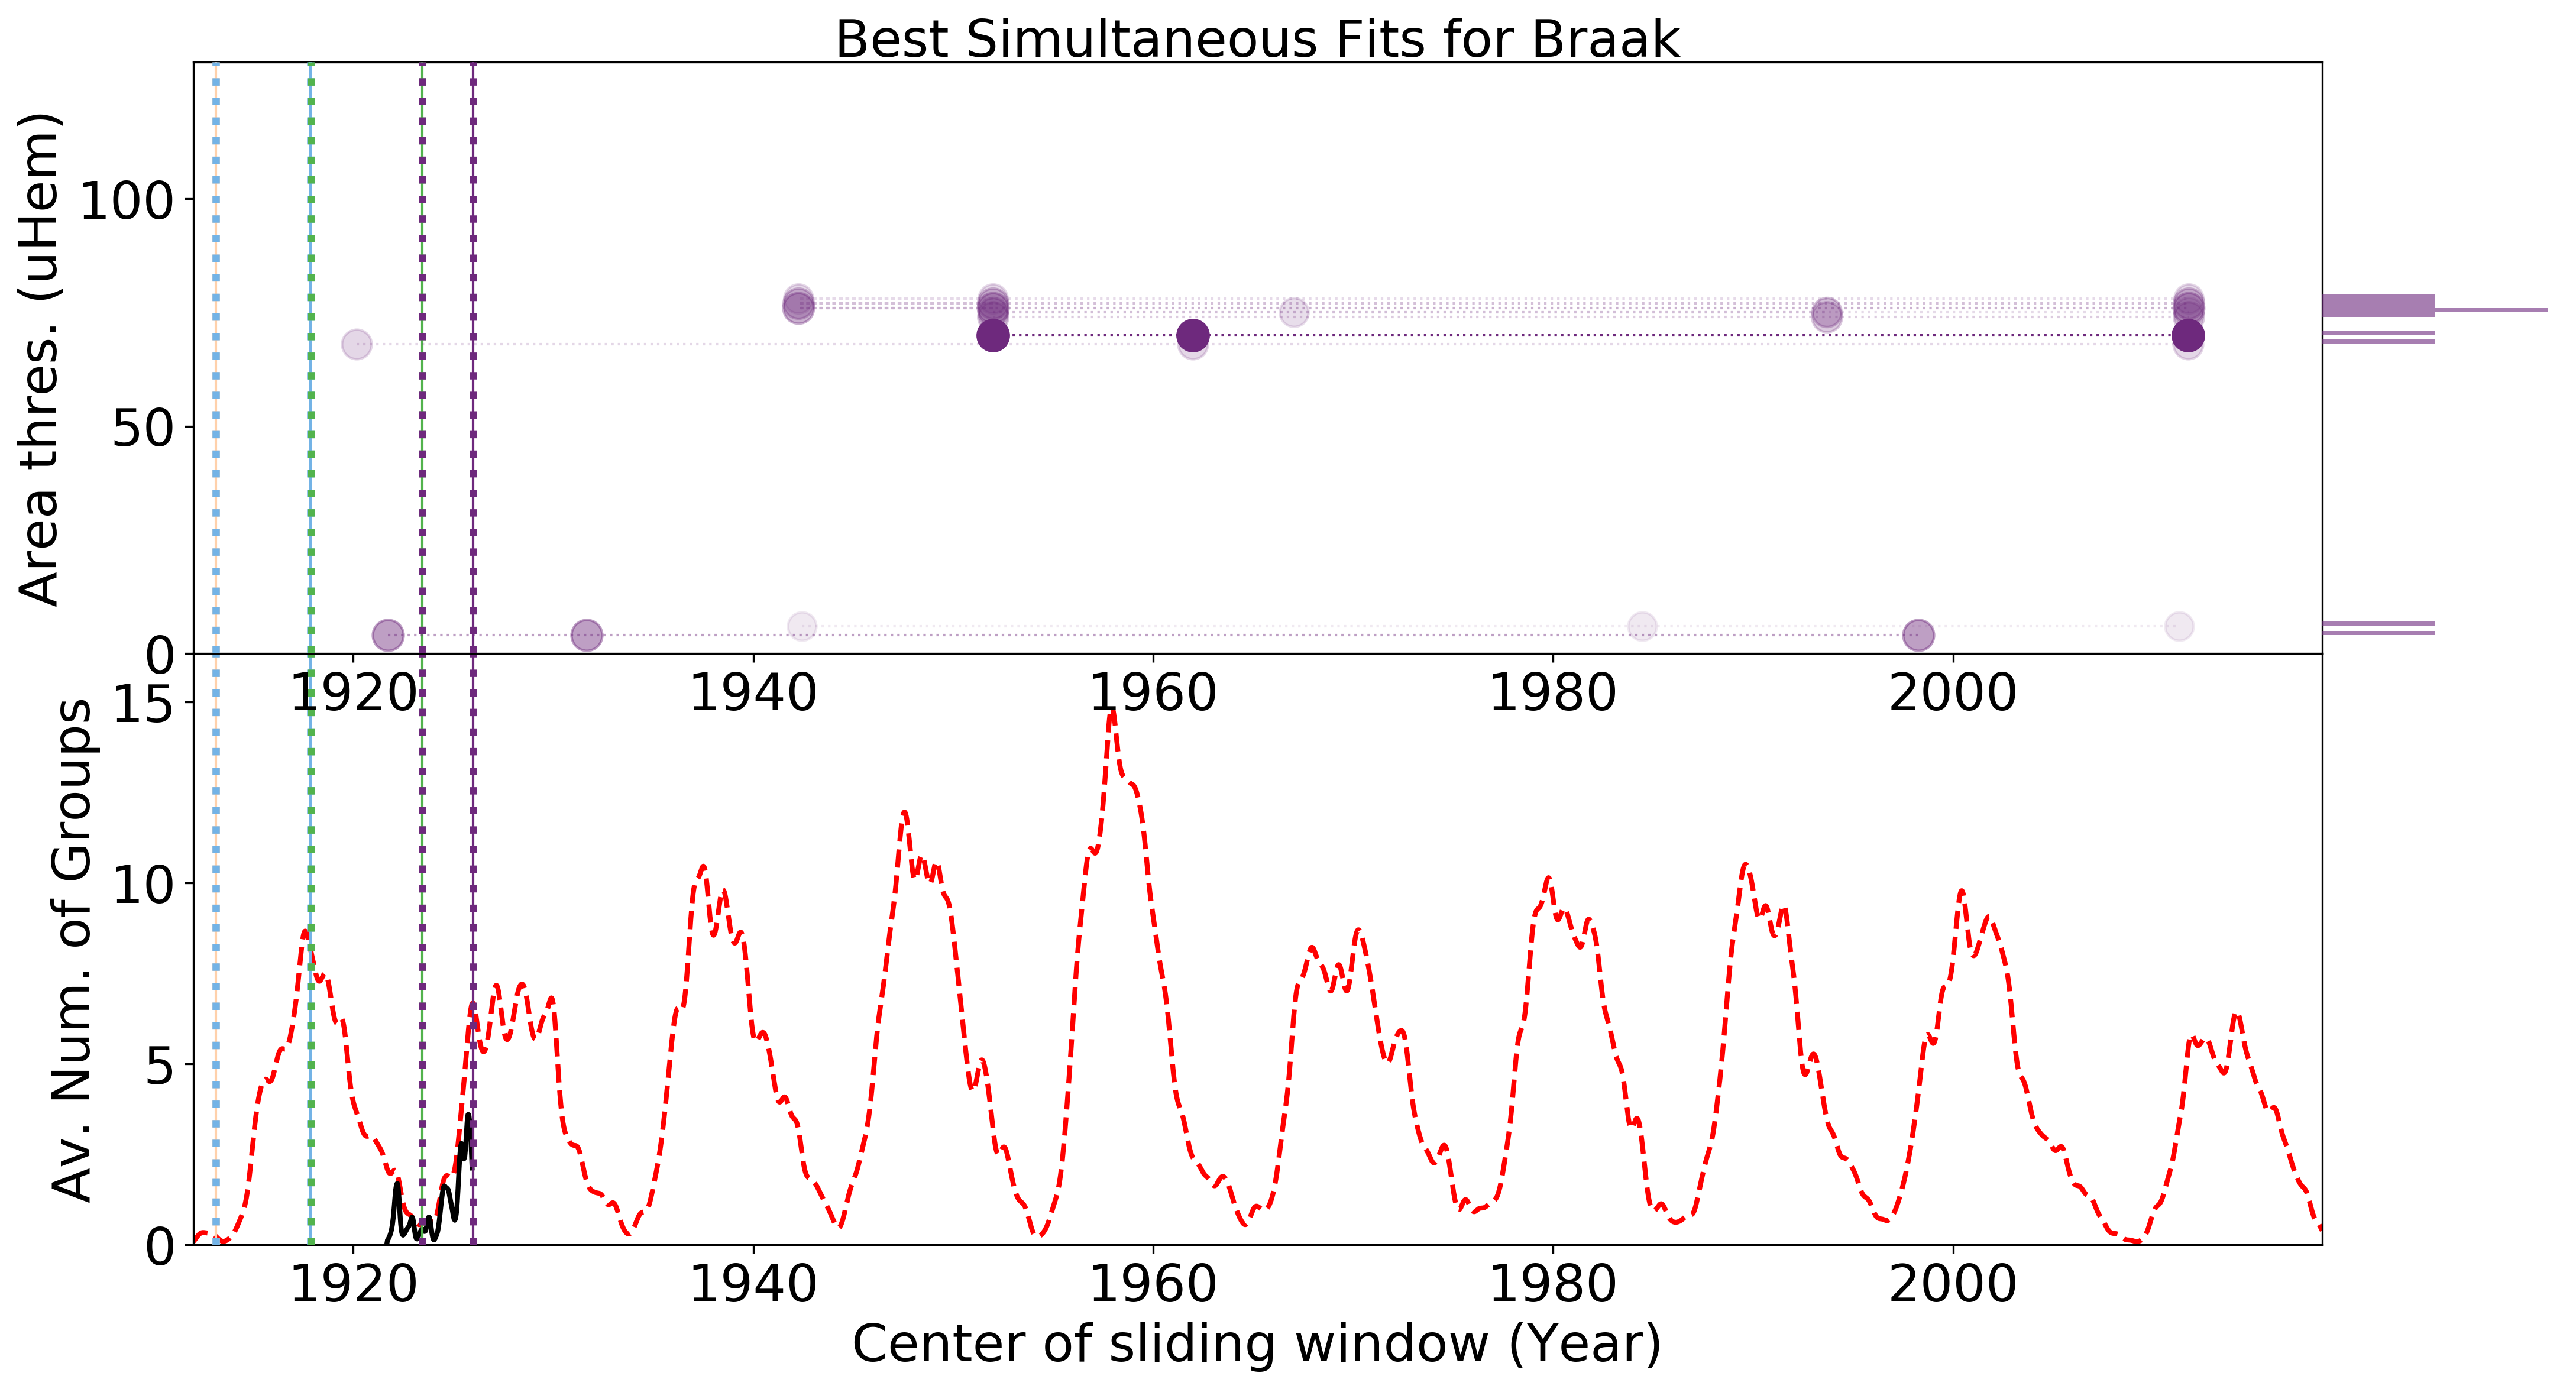

In [34]:
nBest = 50

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel
frc = 0.9    # Fraction of the panel devoted to histogram

nph = 1                       # Number of horizontal panels
npv = 2    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2)

# Axes properties
ax2.set_ylabel('Av. Num. of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)


# Placement of top simultaneous fits
ax1 = fig.add_axes([ppadh, ppadv + (pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv])


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx,0],ObsDat['FRACYEAR']<endPoints[siInx+1,0])
                         ,'FRACYEAR'].values.copy()         
    
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thE]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thE]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thE]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thE]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thE]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thE]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])


for i in range(0,nBest2):
    
    # Initialize plot vector
    x = np.array([])

    for siInx in range(0,cenPoints.shape[0]):
        
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0:
            cadMaskI = risMaskI
            cadMask  = risMaskP
        else:
            cadMaskI = decMaskI
            cadMask  = decMaskP        
        
        Year = REF_Grp['FRACYEAR'].values[cadMaskI]

        # Append only if period is valid
        if vldIntr[siInx]: 
                 
            # If it is the first interval re-create the array
            if x.shape[0] == 0:
                x = np.array([Year[EMDComb[siInx+4,i].astype(np.int)]])
            # Append other sub-intervals     
            else:
                x = np.append(x,Year[EMDComb[siInx+4,i].astype(np.int)]) 
    
    # Creating matching threshold vector
    y = x*0 + EMDComb[1,i]

    # Only plot if using more than one theshold
    if nBest == 1:
        alph = 1
    else:
        # Constructing alpha
        alph = np.clip(1.1-(EMDComb[0,i]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:])),0,1)
      
    # Plotting Intervals
    ax1.plot(x, y,'o:', zorder=11, linewidth = 1, color = Clr[2], alpha = alph, markersize=(101-i)/8)
    
# Axes properties
ax1.set_ylabel('Area thres. (uHem)')
ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
ax1.set_ylim(bottom = thS, top = thE)
    
ax1.text(0.5, 1.01,'Best Simultaneous Fits for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes);

if nBest > 1:
    # Right Distribution
    ax3 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv + (pxy/fszv+ppadv2), pxx/fszh*(1-frc), pxy/fszv])
    ax3.hist(EMDComb[1,:], bins = Thresholds,  color=Clr[2], alpha=.6, orientation = 'horizontal', density = True);

    # # Axes properties
    ax3.set_ylim(bottom = thS, top = thE)
    ax3.set_axis_off()

fig.savefig('testBoth/' + NamObs.capitalize() + '_Simultaneous_Fit_EMD.png', bbox_inches='tight', dpi = 103, pad_inches=0)

print(EMDComb.shape)

**FIGURE:** _Bottom:_ Reference average number of groups (red). True location of the observer groups (black).  Observer sub-intervals (vertical dotted lines).  

_Top:_ Best simultaneous fits obtained using the shifts identified above.  All possible combinations are tested, but only the top _nBest_ are displayed.  Dots denote the optimal shifts and each combination of intervals is joined by a horizontal line denoting the optimal threshold.  Transparency indicates EMD distance: The bolder the system the smaller the distance.  The marginal distribution of thresholds is shown on the right.

## Plotting distribution of Thresholds for the simultaneous fits

In [35]:
EMDComb[0,np.abs(EMDComb[3,:]-EMDComb[2,:])==np.min(np.abs(EMDComb[3,:]-EMDComb[2,:]))]

array([0.01398108])

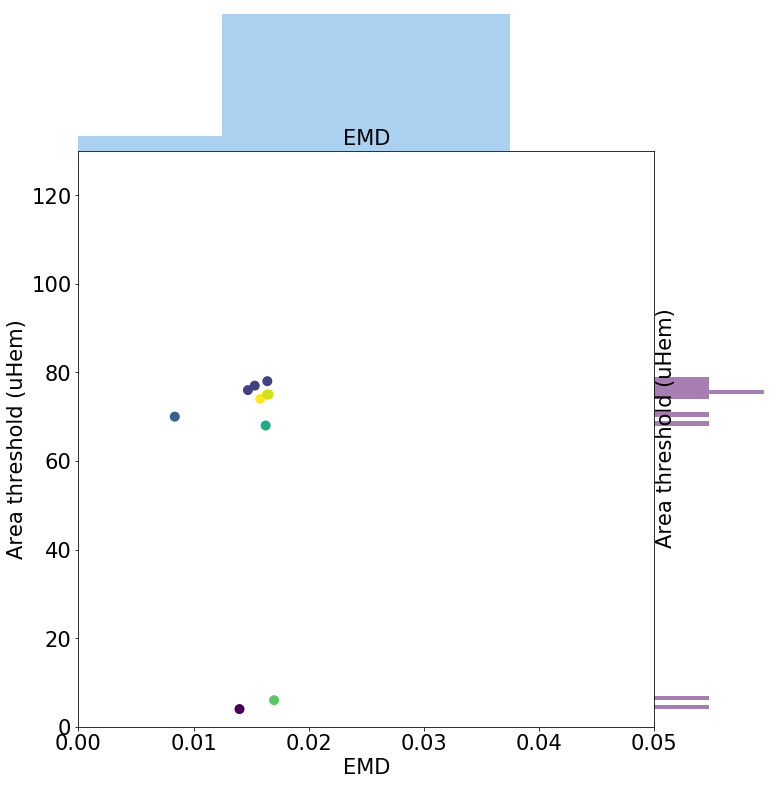

In [36]:
wAv = EMDComb[1,0]

# Only plot if using more than one theshold
if nBest == 1:
    
    # Going through different sub-intervals
    for siInx in range(0,cenPoints.shape[0]):
        wAv = EMDComb[1,0]
        wSD = np.nan
    
else:

    # Distribution Plots of threshold and distance

    # Size definitions
    dpi = 300
    pxx = 3000   # Horizontal size of each panel
    pxy = pxx    # Vertical size of each panel
    frc = 0.8    # Fraction of the panel devoted to histograms

    nph = 1      # Number of horizontal panels
    npv = 1      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 0 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


    # Top Distribution
    axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
    axd.hist(EMDComb[0,:], bins= (np.arange(0,42)-0.5)/40*(np.ceil(np.max(EMDComb[0,:]))-np.floor(np.min(EMDComb[0,:])))
             +np.floor(np.min(EMDComb[0,:])),  color=Clr[4], alpha=.6, density = True);

    # Axes properties
    axd.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = np.ceil(np.max(EMDComb[0,:])))
    axd.set_axis_off()


    # Right Distribution
    ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
    ax2.hist(EMDComb[1,:], bins = np.array(Thresholds),  color=Clr[2], alpha=.6, orientation = 'horizontal', density = True);
    # ax2.plot(yOD, xOD, color=Clr[2], linewidth=3)

    # # Axes properties
    ax2.set_ylim(bottom = 0, top = thE)
    ax2.set_axis_off()

    # Scatter Plot
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
    ax1.scatter(EMDComb[0,:], EMDComb[1,:], c=np.abs(EMDComb[3,:]-EMDComb[2,:]), edgecolor="none", alpha = 1, s=100, linewidths = 2)

    # Constructing weights
    alph = 1-(EMDComb[0,:]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:]))

    # Weighted average
#     wAv = np.sum(np.multiply(alph,EMDComb[1,:]))/np.sum(alph)

    # Weighted Standard Deviation
#     wSD = np.sqrt(np.sum(np.multiply(alph,np.power(EMDComb[1,:]-wAv,2)))/np.sum(alph))

#     ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv, '--'
#              , color = Clr[4], linewidth = 3)
#     ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv-wSD, ':'
#              , color = Clr[4], linewidth = 2)
#     ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv+wSD, ':'
#              , color = Clr[4], linewidth = 2)

    # Axes properties
    ax1.set_ylabel('Area threshold (uHem)')
    ax1.text(1.02, 0.52,'Area threshold (uHem)', horizontalalignment='center', transform = ax1.transAxes, 
             rotation = 'vertical', verticalalignment = 'center')
    ax1.set_xlabel('EMD')
    ax1.text(0.5, 1.01,'EMD', horizontalalignment='center', transform = ax1.transAxes)
    ax1.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = 0.05)#np.ceil(np.max(EMDComb[0,:])))
    ax1.set_ylim(bottom = 0, top = thE);
    
fig.savefig('testBoth/' + NamObs.capitalize() + '_Dis_both_Marg.png', bbox_inches='tight', dpi = 103, pad_inches=0)
    

**FIGURE:** Scatterplot of the optimal EMD distance vs. optimal thresholds, as well as their marginal distributions.   The thick blue line shows the average threshold weighted by distance and the thin blue lines show its weighted standard deviation.

## Scatterplot of Overlapping Reference and Calibrated days

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


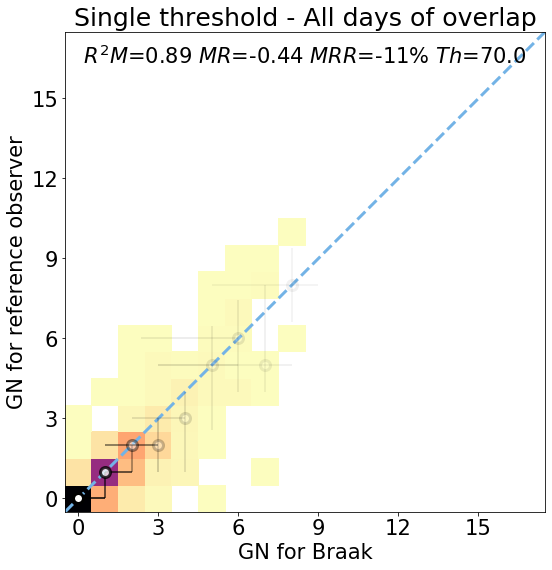

In [37]:
## Test if there is any overlap
if ( np.min(REF_Dat['ORDINAL'])<=np.min(ObsDat['ORDINAL']) ) or ( np.max(REF_Dat['ORDINAL'])>=np.max(ObsDat['ORDINAL']) ):
    
    # Calculating number of groups in reference data for given threshold
    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
    
    # Selecting the days of overlap with calibrated observer
    grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, ObsDat['ORDINAL'].values)]
    grpsObsw = ObsDat.loc[np.in1d(ObsDat['ORDINAL'].values, REF_Dat['ORDINAL'].values),'GROUPS'].values
    
    # Removing NaNs    
    grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
    grpsObsw = grpsObsw[np.isfinite(grpsObsw)]
    
    grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
    grpsREFw = grpsREFw[np.isfinite(grpsREFw)]
    
    plt.rc('font', **font)
    
    # Size definitions
    dpi = 300
    pxx = 2000   # Horizontal size of each panel
    pxy = pxx    # Vertical size of each panel

    nph = 1      # Number of horizontal panels
    npv = 1      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 0 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))
 
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
    
    plotHistSqrtSSN(ax1, grpsREFw, grpsObsw, np.round(wAv,decimals=1), maxNPlt, SqrtF) 
    
    ax1.set_title('Single threshold - All days of overlap')

**FIGURE:** Scatterplot of the Observer vs. the reference after applying the optimal threshold obtained in the step above. Behind the scatterplot is show a color 2D histogram showing the number of points in each block.  The faint dots also indicate less counts.


## Scatterplot of Overlapping Reference and Calibrated days using a different threshold for each interval

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater


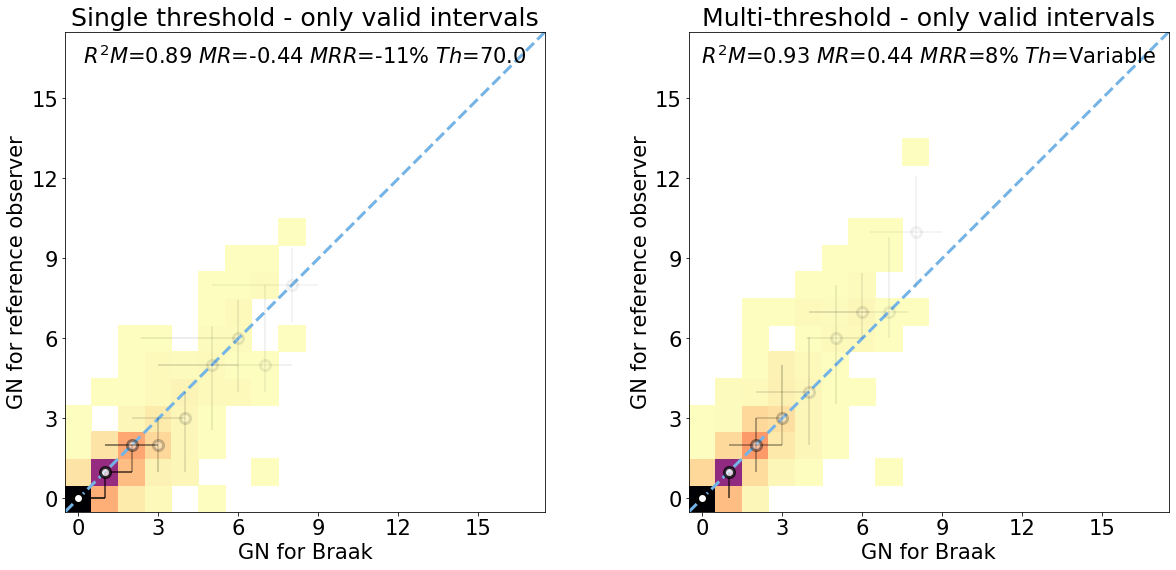

In [38]:
# Test if there is any overlap
if calRef.shape[0]>1:
            
    plt.rc('font', **font)
    
    # Size definitions
    dpi = 300
    pxx = 2500   # Horizontal size of each panel
    pxy = pxx    # Vertical size of each panel

    nph = 2      # Number of horizontal panels
    npv = 1      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 50 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

    calRefT = calRef.copy()
    calObsT = calObs.copy()

    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))
    
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b1')

    calRefN = np.array([0])
    calObsN = np.array([0])
    
    calRefNmt = np.array([0])
    calObsNmt = np.array([0])
    
    for n in range(0,cenPoints.shape[0]):
    
        # Plot only if the period is valid and has overlap
        if vldIntr[n] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[n, 0],REF_Dat['FRACYEAR']<endPoints[n+1, 0]))>0:

            # Calculating number of groups in reference data for given threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

            # Selecting observer's interval
            TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'GROUPS'].values.copy()
            TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'ORDINAL'].values.copy()

            # Selecting the days of overlap with calibrated observer
            grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
            grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]

            # Removing NaNs    
            grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
            grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

            grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
            grpsREFw = grpsREFw[np.isfinite(grpsREFw)]


            # Appending to calibrated arrays
            calRefN = np.append(calRefN,grpsREFw)
            calObsN = np.append(calObsN,grpsObsw)
            
            
            # Calculating number of groups in reference data for given the interval threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAvI[n]) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

            # Selecting observer's interval
            TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'GROUPS'].values.copy()
            TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'ORDINAL'].values.copy()

            # Selecting the days of overlap with calibrated observer
            grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
            grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]

            # Removing NaNs    
            grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
            grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

            grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
            grpsREFw = grpsREFw[np.isfinite(grpsREFw)]


            # Appending to calibrated arrays
            calRefNmt = np.append(calRefNmt,grpsREFw)
            calObsNmt = np.append(calObsNmt,grpsObsw)            
            

    # Calculating goodness of fit of Y=X
    
    if np.sum(vldIntr) > 1:
        thTxt = 'Variable'
        titlTxt1 = 'Single threshold - only valid intervals'
        titlTxt2 = 'Multi-threshold - only valid intervals'
    else:
        thTxt = wAvI[vldIntr][0]
        titlTxt1 = 'Single threshold restricted to best EMD'            
        titlTxt2 = 'Single threshold free to float'            
            
                
    plotHistSqrtSSN(ax1, calRefN, calObsN, np.round(wAv,decimals=1), maxNPlt, SqrtF)
    
    ax1.set_title(titlTxt1)
    
    ax2 = fig.add_axes([ppadh + (pxx/fszh+ppadh2), ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b2')

    plotHistSqrtSSN(ax2, calRefNmt, calObsNmt, thTxt, maxNPlt, SqrtF)
    
    ax2.set_title(titlTxt2)
    
    
fig.savefig('testBoth/' + NamObs.capitalize() + 'Thres_vs_MT_Scatter.png', bbox_inches='tight', dpi = 103, pad_inches=0)



**FIGURE:** Scatterplot of the Observer vs. the reference.  **As opposed to the one above, this scatter plot uses different thresholds for different intervals.  The scatterplot is performed by merging all the scatterplots shown in the** [**Figure Above**](#scatterPlots) 

Behind the scatterplot is show a color 2D histogram showing the number of points in each block.  The faint dots also indicate less counts.

# Plotting comparison the observer's group vs. RGO (total and optimal threshold) groups

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


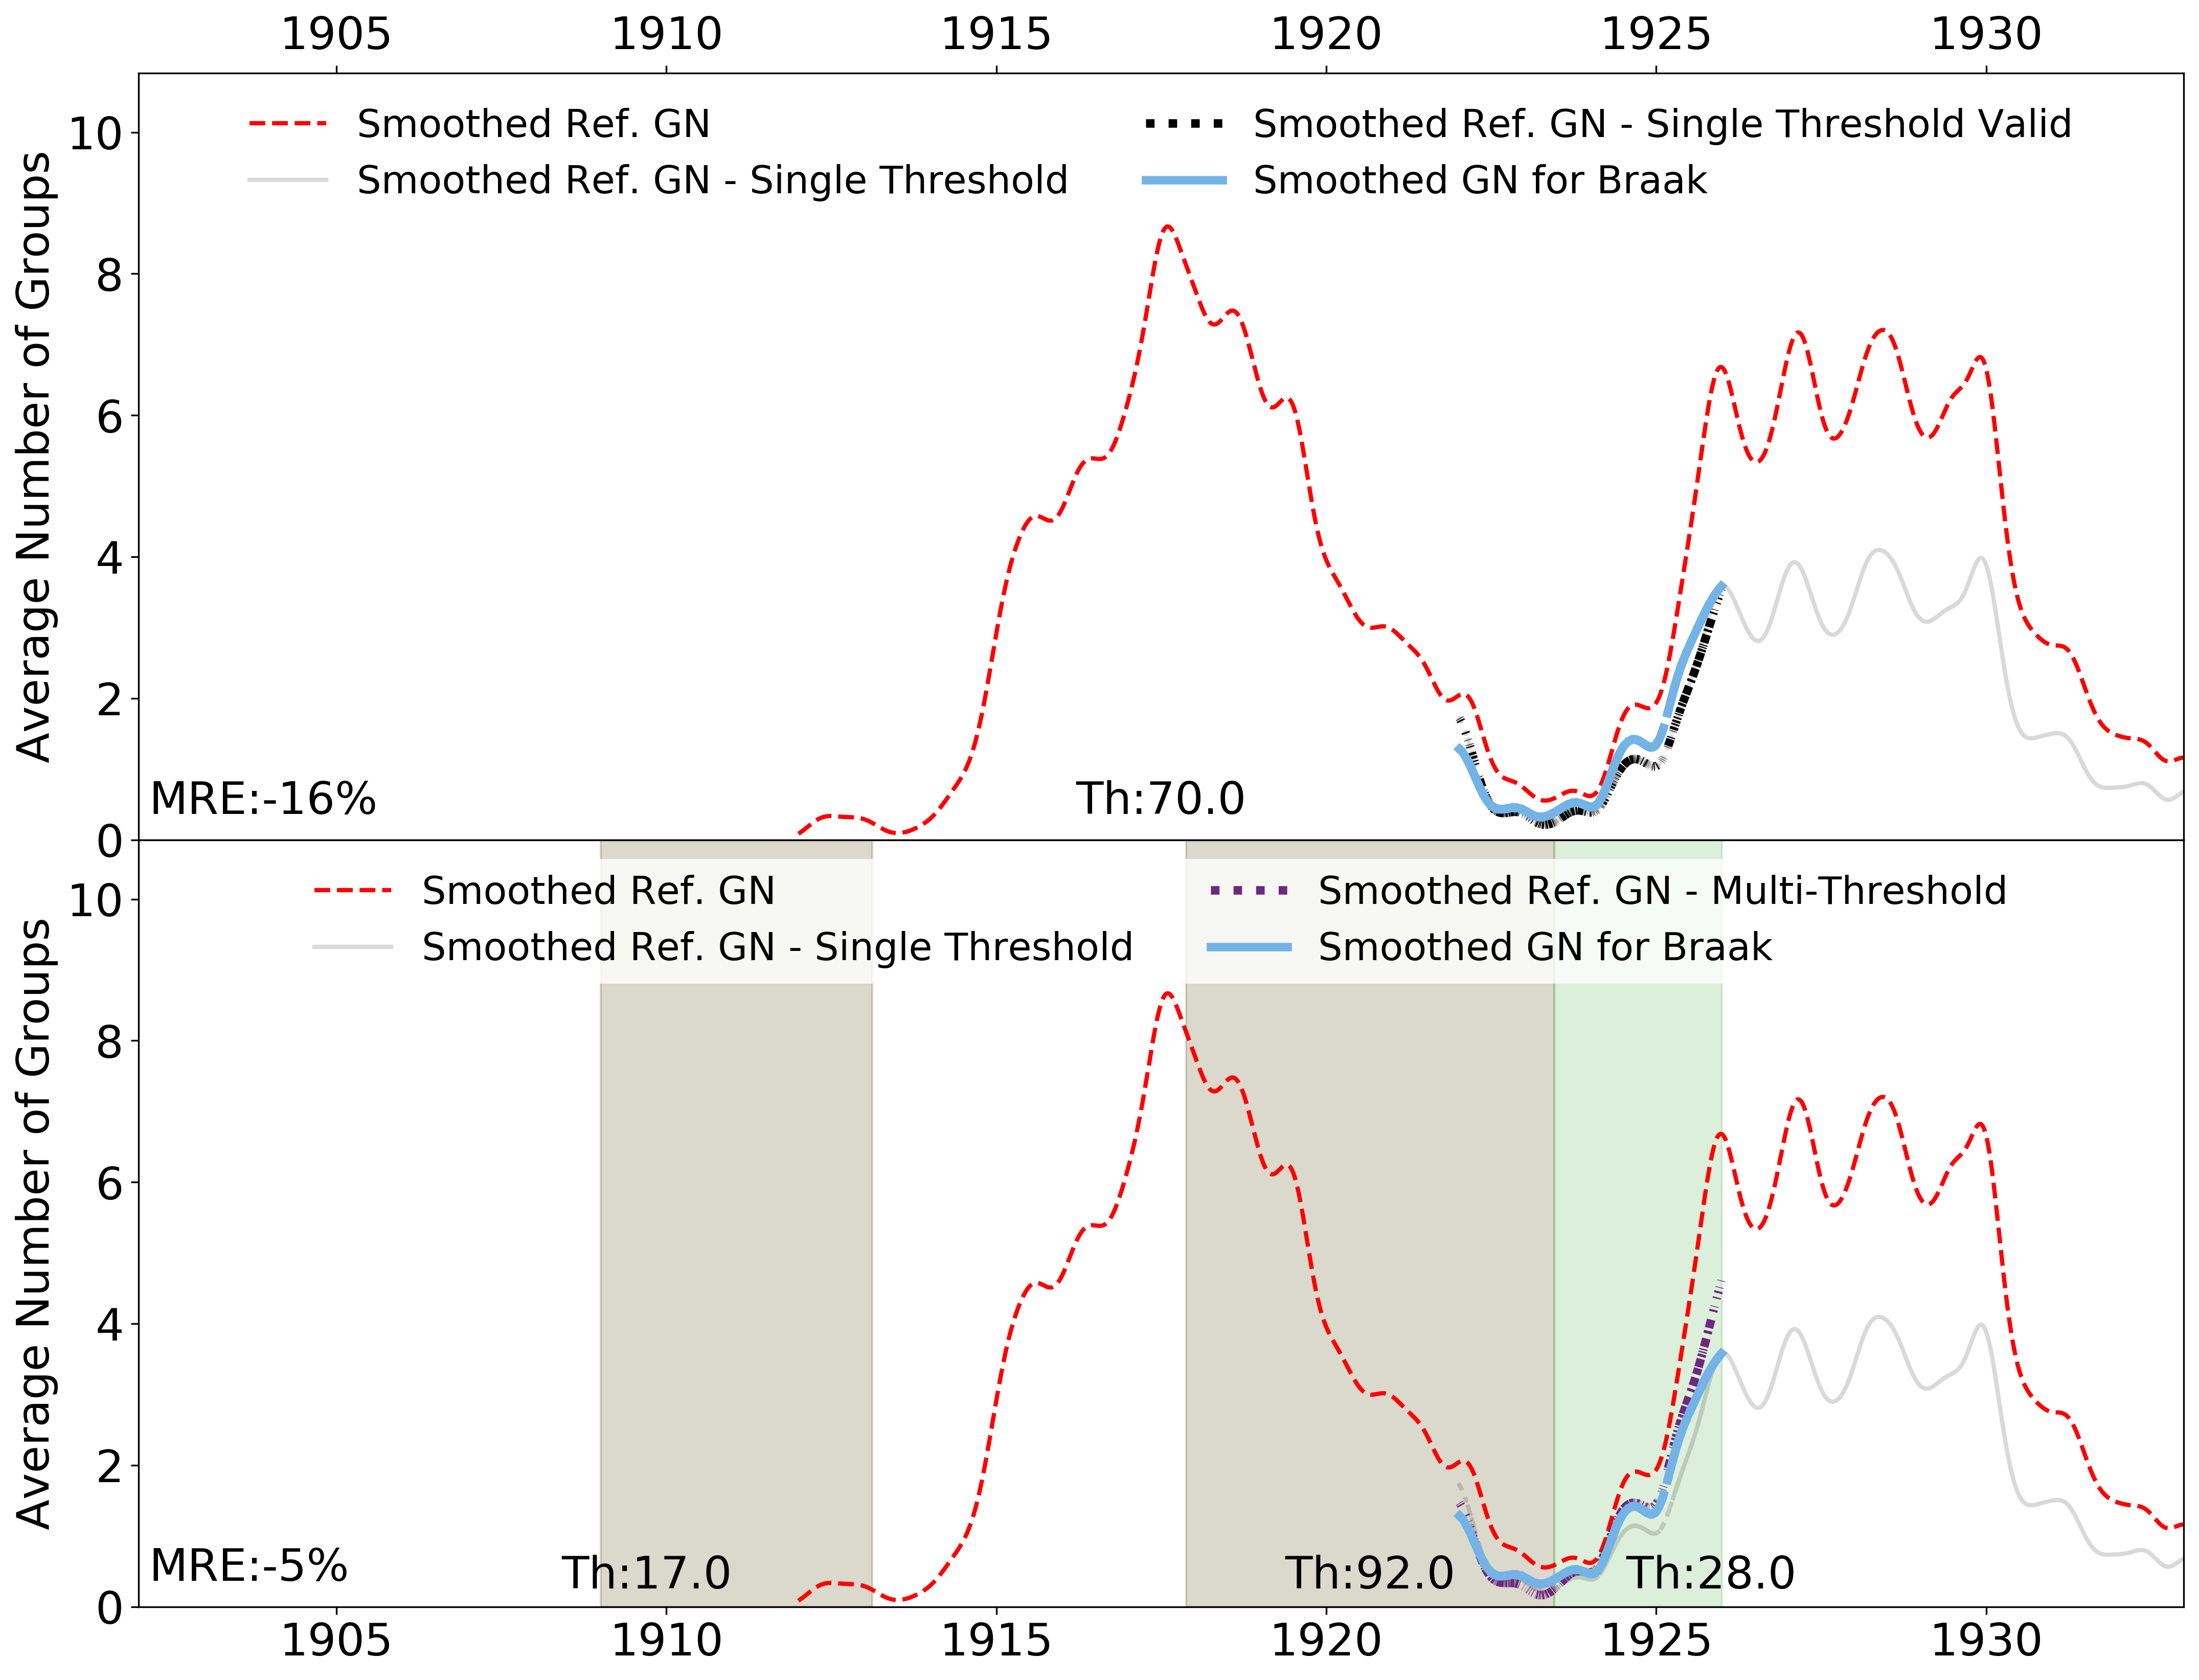

In [39]:
# Creating variables for plotting
Grp_Comp = REF_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()

# Raw Ref Groups
Grp_Comp['GROUPS'] = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],0) ,axis = 1)
Grp_Comp['GROUPS'] = Grp_Comp['GROUPS'].astype(float)

# Thresholded Ref Groups
Grp_Comp['SINGLETH'] =  np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
Grp_Comp['SINGLETHVI'] =  Grp_Comp['SINGLETH']

# Multi-Threshold Ref Groups
Grp_Comp['MULTITH'] = Grp_Comp['SINGLETH']*np.nan
for n in range(0,cenPoints.shape[0]):

    # Plot only if the period is valid and has overlap
    if vldIntr[n] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[n, 0],REF_Dat['FRACYEAR']<endPoints[n+1, 0]))>0:
        
        intervalmsk = np.logical_and(Grp_Comp['FRACYEAR']>=endPoints[n, 0],Grp_Comp['FRACYEAR']<endPoints[n+1, 0])
        Grp_Comp.loc[intervalmsk,'MULTITH'] = np.nansum( np.greater(REF_Dat.values[intervalmsk,3:REF_Dat.values.shape[1]-3],wAvI[n]) ,axis = 1).astype(float)

# Calibrated Observer
Grp_Comp['CALOBS'] = Grp_Comp['SINGLETH']*np.nan
Grp_Comp.loc[np.in1d(REF_Dat['ORDINAL'].values, ObsDat['ORDINAL'].values),'CALOBS'] = ObsDat.loc[np.in1d(ObsDat['ORDINAL'].values, REF_Dat['ORDINAL'].values),'GROUPS'].values
        
# Imprinting Calibrated Observer NaNs
nanmsk = np.isnan(Grp_Comp['CALOBS'])
Grp_Comp.loc[np.logical_and(np.in1d(REF_Dat['ORDINAL'].values, ObsDat['ORDINAL'].values), nanmsk),['CALOBS','SINGLETH','MULTITH']] = np.nan

# Imprinting Reference NaNs
Grp_Comp.loc[np.isnan(REF_Dat['AREA1']),['CALOBS','SINGLETH','MULTITH']] = np.nan

# Adding a Calibrated observer only in valid intervals
Grp_Comp['CALOBSVI'] = Grp_Comp['CALOBS']
Grp_Comp.loc[np.isnan(Grp_Comp['MULTITH']),'CALOBSVI'] = np.nan

Grp_Comp.loc[np.isnan(Grp_Comp['CALOBS']),'SINGLETHVI'] = np.nan


# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
Grp_Comp['GROUPS']  = conv.convolve(Grp_Comp['GROUPS'].values, Gss_1D_ker, preserve_nan=True)
Grp_Comp['SINGLETH']  = conv.convolve(Grp_Comp['SINGLETH'].values, Gss_1D_ker, preserve_nan=True)
Grp_Comp['SINGLETHVI']  = conv.convolve(Grp_Comp['SINGLETHVI'].values, Gss_1D_ker, preserve_nan=True)
Grp_Comp['MULTITH']  = conv.convolve(Grp_Comp['MULTITH'].values, Gss_1D_ker, preserve_nan=True)
Grp_Comp['CALOBS']  = conv.convolve(Grp_Comp['CALOBS'].values, Gss_1D_ker, preserve_nan=True)
Grp_Comp['CALOBSVI']  = conv.convolve(Grp_Comp['CALOBSVI'].values, Gss_1D_ker, preserve_nan=True)

maxplt= np.max(Grp_Comp.loc[np.in1d(REF_Dat['ORDINAL'].values, ObsDat['ORDINAL'].values),'GROUPS'])


# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1500   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
ax2 = fig.add_axes([ppadh, ppadv+pxy/fszv, pxx/fszh, pxy/fszv])

pltx = Grp_Comp['FRACYEAR']

ax2.plot(pltx, Grp_Comp['GROUPS'], 'r--', linewidth = 2, alpha = 1) 
ax2.plot(pltx, Grp_Comp['SINGLETH'], 'k', linewidth = 2, alpha = 0.15) 
ax2.plot(pltx, Grp_Comp['SINGLETHVI'], 'k:', linewidth = 4, alpha = 1) 

ax2.plot(pltx, Grp_Comp['CALOBS'], color = Clr[4], linewidth = 4, alpha = 1) 

ax2.set_xlim(left = np.min(ObsDat['FRACYEAR'])-7, right = np.max(ObsDat['FRACYEAR'])+7);
ax2.set_ylim(bottom = 0, top = maxplt*1.25)
ax2.xaxis.tick_top()
ax2.set_ylabel('Average Number of Groups')

ax2.text(0.5, 0.05,'Th:' + str(np.round(wAv,decimals=1)), horizontalalignment='center', verticalalignment='center',transform=ax2.transAxes)
ax2.legend(['Smoothed Ref. GN','Smoothed Ref. GN - Single Threshold','Smoothed Ref. GN - Single Threshold Valid','Smoothed GN for ' + NamObs.capitalize()], loc = 'upper center', ncol = 2, frameon = True, edgecolor = 'none', fontsize=18)

MRE = np.round(np.nanmean(np.divide(Grp_Comp['SINGLETHVI']-Grp_Comp['CALOBS'],Grp_Comp['CALOBS']))*100, decimals=0)
ax2.text(0.005, 0.05,'MRE:' + str(int(MRE)) + '%', horizontalalignment='left', verticalalignment='center',transform=ax2.transAxes)


ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

# Plotting Observer
ax1.plot(pltx, Grp_Comp['GROUPS'], 'r--', linewidth = 2, alpha = 1) 
ax1.plot(pltx, Grp_Comp['SINGLETH'], 'k', linewidth = 2, alpha = 0.15) 
ax1.plot(pltx, Grp_Comp['MULTITH'], color = Clr[2], linestyle = ':', linewidth = 4, alpha = 1) 

ax1.plot(pltx, Grp_Comp['CALOBSVI'], color = Clr[4], linewidth = 4, alpha = 1) 

ax1.set_xlim(left = np.min(ObsDat['FRACYEAR'])-7, right = np.max(ObsDat['FRACYEAR'])+7);
ax1.set_ylim(bottom = 0, top = maxplt*1.25)
ax1.set_ylabel('Average Number of Groups')

ax1.legend(['Smoothed Ref. GN','Smoothed Ref. GN - Single Threshold','Smoothed Ref. GN - Multi-Threshold','Smoothed GN for ' + NamObs.capitalize()], loc = 'upper center', ncol = 2, frameon = True, edgecolor = 'none', fontsize=18)

MRE = np.round(np.nanmean(np.divide(Grp_Comp['MULTITH']-Grp_Comp['CALOBSVI'],Grp_Comp['CALOBSVI']))*100, decimals=0)
ax1.text(0.005, 0.05,'MRE:' + str(int(MRE)) + '%', horizontalalignment='left', verticalalignment='center',transform=ax1.transAxes)


for Idx in range(0,cenPoints.shape[0]):
    if vldIntr[Idx]:
        ax1.fill([endPoints[Idx, 0], endPoints[Idx, 0], endPoints[Idx+1, 0], endPoints[Idx+1, 0]], [0, maxplt*1.25, maxplt*1.25, 0 ], color = Clr[1+np.mod(Idx,2)*2], alpha = 0.2, linestyle = None)
        ax1.text(cenPoints[Idx, 0], maxplt*0.05,'Th:' + str(np.round(wAvI[Idx],decimals=1)) , horizontalalignment='center', verticalalignment='center')
        
fig.savefig('testBoth/' + NamObs.capitalize() + 'Comparison.png', bbox_inches='tight', dpi = 103, pad_inches=0)
        